# Introduction

## Muon Tomography for Nuclear Waste Characterization Using Machine Learning

Muons are fundamental particles belonging to the lepton group, which also includes electrons and neutrinos. They are similar to electrons but have a mass approximately 207 times greater [1], allowing them to penetrate deeply into dense materials due to reduced deceleration radiation compared to electrons. Muons are produced in large quantities when cosmic rays interact with the Earth's atmosphere, creating particles like pions, which decay into muons. These muons can travel significant distances before decaying, often penetrating more than a mile into the Earth’s surface​.

Muon tomography leverages the penetrating power of muons to investigate dense and otherwise opaque structures. This technique has been successfully applied in diverse fields, including archaeology (e.g., exploring chambers in the Great Pyramid) [2] and nuclear applications (e.g., the characterization of nuclear waste containers, a critical task for ensuring safe handling, storage, and disposal of radioactive materials). Its potential lies in providing high-resolution images with minimal disruption to the observed structures.

 In this notebook, I explore machine learning methodologies to enhance the analysis pipeline for muon tomography data. Specifically, I address the following:

- Simulating and Augmenting Muon Tomography Data: Generating synthetic datasets to train and validate models, incorporating noise and variability to mimic real-world conditions.

- Baseline CNN Model: Develop a simple two-layered (for demonstration purposes, more complex, deeper models can be developed) convolutional neural network (CNN) to classify materials based on simulated muon interactions.

- Statistical Methods for Enhanced Accuracy: Integrate techniques such as Poisson distribution, Markov models, survival analysis to quantify and incorporate particles interactions with containers.

- Zonotopic Dempster-Shafer Structures (DSZ): Combining Dempster-Shafer Theory (DST) with zonotopic representations to robustly model and visualize uncertainties produced during muon tomography data collection.

- GoogleNet with transfer learning: Compare results of the previous methods with more robust architectures such as GoogleNet already trained for image classification tasks and use transfer learning to fine-tune the model for muon tomography data.


## Relevance to Nuclear Waste Management

Muon tomography's ability to scan dense objects without physical intrusion makes it a compelling tool for nuclear waste management. The safe handling of nuclear waste requires precise information about container contents, including material type, density, and arrangement. Machine learning, paired with physics-based models like Monte Carlo simulations, can accelerate analysis, improve accuracy, and enable real-time decision-making.



This notebook is divided into the following sections:

1. Data Simulation and Augmentation:

  - Creation of synthetic muon interaction images.

  - Noise injection and Monte Carlo-based data augmentation.



2. Baseline CNN Implementation:

  - Training and evaluation of a basic CNN for material classification.



3. Statistical Methods:

  - Use of Poisson distributions, Markov transition models, and survival analysis to refine predictions.



4. DSZ Implementation:

  - Integrating belief, plausibility, and probabilistic generators into a unified zonotopic framework.

5. GoogleNet architecture:

  - Use pre-trained weights and fine-tune them for material classification of muography data and compare performance of different architectures and methods.


6. Results and Comparisons:

  - Comparative analysis of the baseline CNN,enhanced models using statistical and zonotopic methods and other CNN architectures.




Conclusion

This work demonstrates the application of advanced machine learning techniques to a challenging physics-based problem. The integration of statistical and zonotopic models provides a pathway for more reliable, interpretable, and efficient analysis pipelines for nuclear waste characterization.


---

References:

[1] U.S. Department of Energy: https://www.energy.gov/science/doe-explainsmuons

[2] CERN: https://muoncollider.web.cern.ch/history-muon

# Generate simulated data

Nuclear waste containers are typically made from robust materials such as steel, lead, copper, stainless steel, titanium, and other alloys, chosen for their corrosion resistance and structural integrity. These materials are designed to safely store and isolate radioactive waste over long periods​ [1].

Based on this, I simulated data of scattering of muons traversing these materials based on their densities [2][3].

Besides creating simulated data, I also add noise and augment it with a Monte Carlo-based approach

[1] World Nuclear Association: https://world-nuclear.org/information-library/nuclear-fuel-cycle/nuclear-waste/storage-and-disposal-of-radioactive-waste#interim-waste-storage-and-transport

[2] Matmake: https://matmake.com/properties/density-of-common-materials.html

[3] The Engineering Toolbox: https://www.engineeringtoolbox.com/metal-alloys-densities-d_50.html

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input
import tensorflow as tf
import random
import pandas as pd

# Material Densities for Simulations
material_densities = {
    "Steel": 7850,  # kg/m^3
    "Lead": 11340, # kg/m^3
    "Concrete": 2400,
    "Water": 1000,
    "Uranium": 19050,  # kg/m^3, radioactive material
    "Plutonium": 19840, # kg/m^3, radioactive material
    "Cesium": 18700,  # kg/m^3, radioactive material
    "Cobalt": 8900   # kg/m^3, radioactive material
}

# Function to create base image with random material placement
def create_base_image(container_size=(64, 64), num_materials=4):
    """
    Generate base image with random material placement.

    Args:
        container_size: size of the image
        num_materials: number of materials to place in the image

    Returns:
        Image with random material placement

    """
    image = np.zeros(container_size)
    materials = np.random.choice(list(material_densities.keys()), size=num_materials, replace=True)
    for material in materials:
        region = np.random.randint(0, container_size[0], size=2)
        size = np.random.randint(5, 15)  # Random size of material region
        image[region[0]:region[0] + size, region[1]:region[1] + size] = material_densities[material]
    return image, materials

# Add noise to simulate measurement uncertainty
def add_noise_to_image(image, noise_level=0.1):
    """
    Add Gaussian noise to an image.

    Args:
        image: Input image
        noise_level: Standard deviation of the Gaussian noise

    Returns:
        Noisy image

    """
    noisy_image = image + np.random.normal(0, noise_level * np.max(image), image.shape)
    return np.clip(noisy_image, 0, None)  # Ensure no negative densities

# Generate dataset of images and labels
def generate_dataset(num_samples=1000, container_size=(64, 64), num_materials=4):
    """
    Generate dataset with noise and augmentation.

    Args:
        num_samples: Number of samples to generate
        container_size: Size of the image
        num_materials: Number of materials to place in the image

    Returns:
        Images and labels

    """
    images, labels = [], []
    for _ in range(num_samples):
        base_image, materials = create_base_image(container_size, num_materials)
        noisy_image = add_noise_to_image(base_image)
        images.append(noisy_image)
        labels.append(materials)  # Labels are material types in the container
    return np.array(images), labels

# Generate Baseline Dataset
X, y = generate_dataset()
X = X[..., np.newaxis]  # Add channel dimension for CNN

In [ ]:
# Create a DataFrame for visualization
df = pd.DataFrame(columns=['Image', 'Materials'])

# Iterate through the generated data and add to the DataFrame
for i in range(len(X)):
    df.loc[i] = [X[i], y[i]]

# Display the DataFrame
display(df)

,Image,Materials
0,"[[[1372.3521346538594], [0.0], [0.0], [50.9755...","[Cobalt, Lead, Uranium, Steel]"
1,"[[[0.0], [1148.9547925546667], [0.0], [2018.46...","[Concrete, Lead, Concrete, Uranium]"
2,"[[[2168.1101773822875], [0.0], [0.0], [616.493...","[Uranium, Concrete, Cesium, Water]"
3,"[[[653.3159416321608], [1334.5443684459715], [...","[Steel, Concrete, Plutonium, Cobalt]"
4,"[[[115.86998105663942], [0.0], [960.1949481495...","[Water, Cobalt, Cobalt, Lead]"
...,...,...
995,"[[[0.0], [1000.8234075994371], [0.0], [113.456...","[Water, Steel, Steel, Concrete]"
996,"[[[1363.8152811418138], [399.2921716579078], [...","[Steel, Lead, Water, Uranium]"
997,"[[[2665.9912085471], [0.0], [0.0], [1921.50998...","[Steel, Cobalt, Uranium, Lead]"
998,"[[[1118.9091294391944], [0.0], [0.0], [0.0], [...","[Steel, Steel, Plutonium, Lead]"


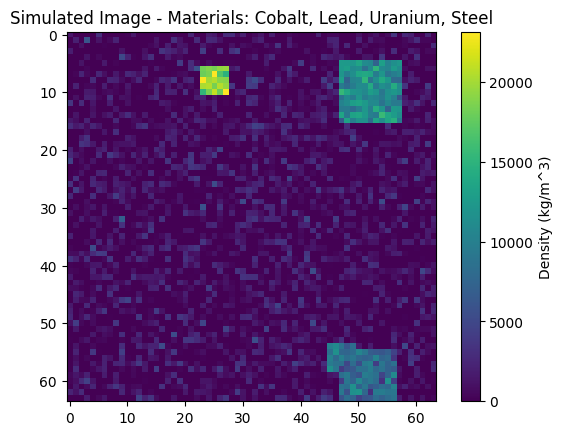

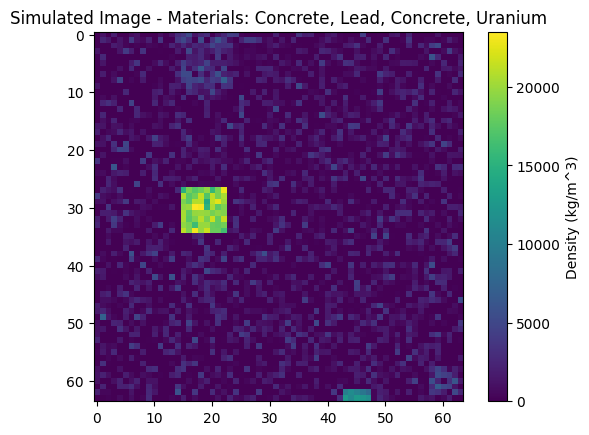

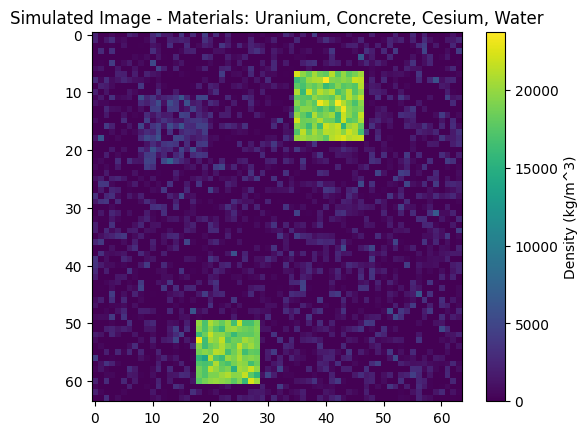

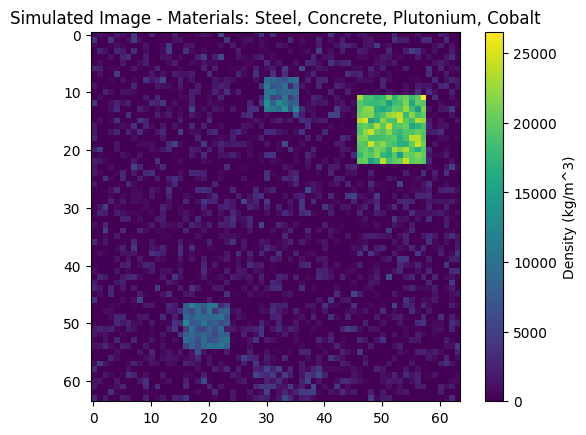

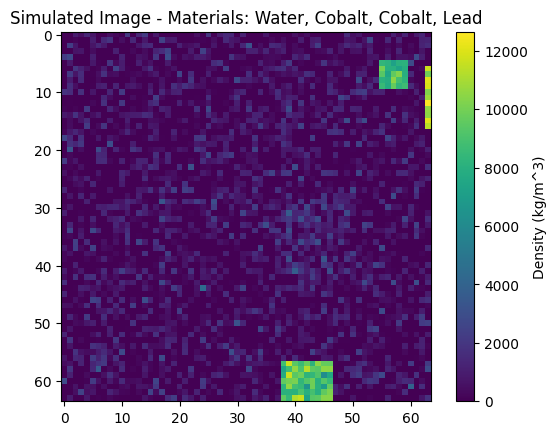

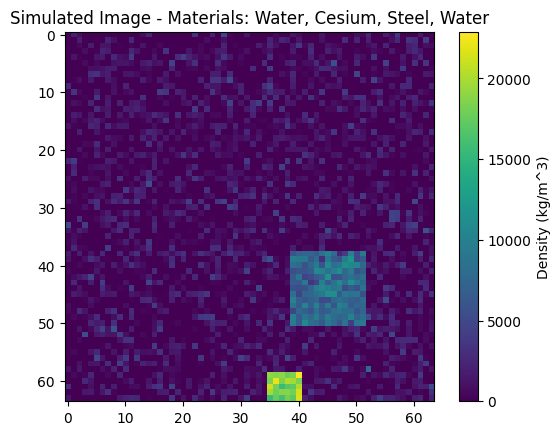

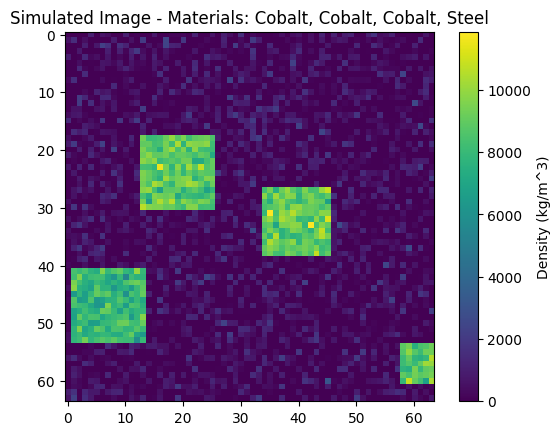

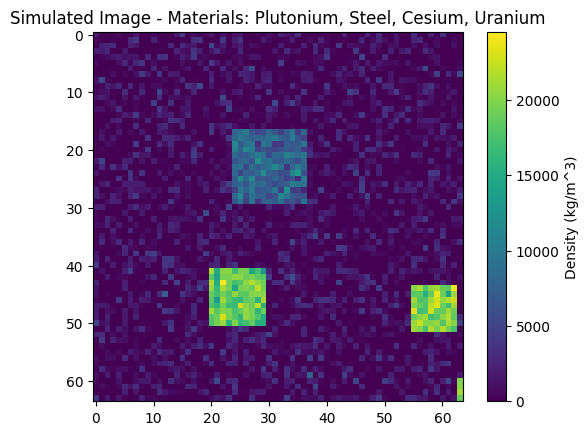

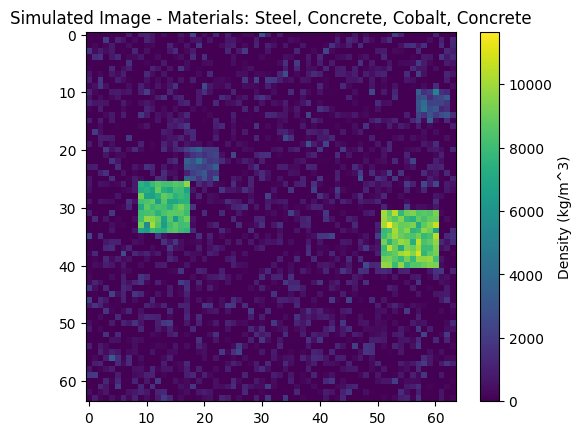

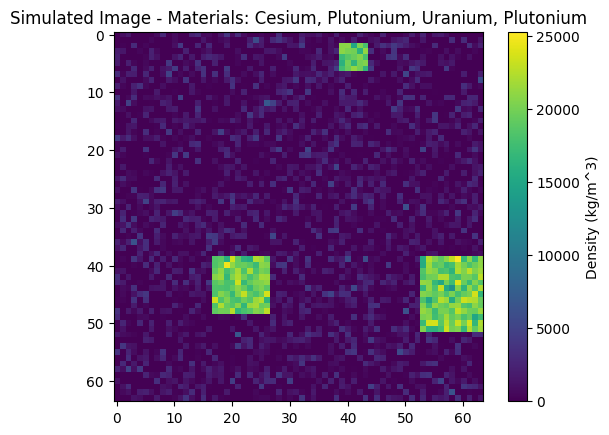

In [ ]:
import matplotlib.pyplot as plt

for i in range(min(10, len(X))):  # Display up to 10 images
    plt.figure()  # Create a new figure for each image
    plt.imshow(X[i].squeeze(), cmap='viridis')  # Display the image
    plt.colorbar(label='Density (kg/m^3)')  # Add colorbar
    plt.title(f"Simulated Image - Materials: {', '.join(y[i])}")  # Set title with materials
    plt.show()

# Create the baseline Convolutional Neural Network

Create a simple CNN with two hidden layers, each with max pooling to extract the predominant features, a fully connected layer and a final multiclass layer.

In [ ]:
# Encode Labels (Material Types) for Classification
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping

mlb = MultiLabelBinarizer()
y_encoded = mlb.fit_transform(y)

# Set random seeds for reproducibility
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

# Normalize the dataset
scaler = MinMaxScaler()

X_flattened = X.reshape(-1, 64 * 64)  # Flatten images
X_normalized = scaler.fit_transform(X_flattened).reshape(-1, 64, 64, 1)

# Spli data into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y_encoded, test_size=0.2, random_state=42)

def create_model(input_shape):
  """
  Create a simple CNN model.

  Args:
      input_shape: Shape of the input data.

  Returns:
      CNN model.
  """
  cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(len(mlb.classes_), activation='softmax')  # Multi-class classification output
  ])

  # Compile the model
  cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

  return cnn_model

# stop training after 3 iterations of non-improvement and restore best weights
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# store model in a variable
cnn_model = create_model(input_shape=(64, 64, 1))

# Train Baseline CNN
history_baseline = cnn_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Evaluate Baseline CNN
baseline_loss, baseline_accuracy = cnn_model.evaluate(X_test, y_test)
print(f"Baseline CNN - Loss: {baseline_loss}, Accuracy: {baseline_accuracy}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 93ms/step - accuracy: 0.0613 - loss: 8.6873 - val_accuracy: 0.0050 - val_loss: 21.3776
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.1035 - loss: 34.8695 - val_accuracy: 0.3850 - val_loss: 90.4843
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1589 - loss: 272.4465 - val_accuracy: 0.0000e+00 - val_loss: 972.9398
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0967 - loss: 1466.3729 - val_accuracy: 0.0000e+00 - val_loss: 2220.2046
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0019 - loss: 22.0854     
Baseline CNN - Loss: 21.37761878967285, Accuracy: 0.004999999888241291


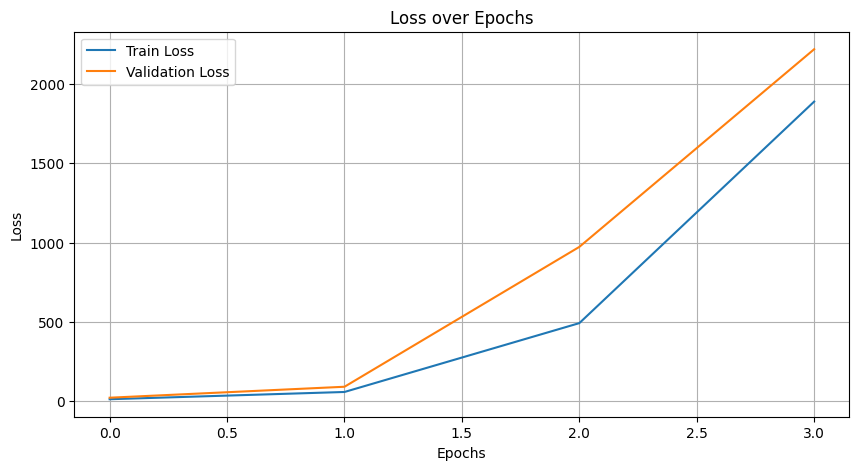

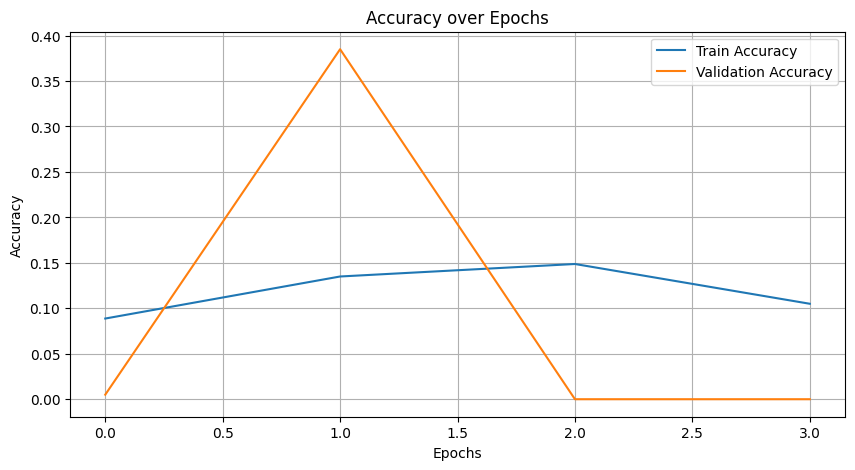

In [ ]:
# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(history_baseline.history['loss'], label='Train Loss')
plt.plot(history_baseline.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(history_baseline.history['accuracy'], label='Train Accuracy')
plt.plot(history_baseline.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()


## Augment data with Monte Carlo Simulation

In [ ]:
def monte_carlo_augmentation(image, num_samples=10, noise_level=0.1):
    """
    Generate augmented images using Monte Carlo simulation.

    Args:
        image: Input image
        num_samples: Number of augmented images to generate
        noise_level: Standard deviation of the Gaussian noise

    Returns:
        List of augmented images

    """
    return np.array([add_noise_to_image(image, noise_level) for _ in range(num_samples)])

# set empty lists to store images
augmented_X, augmented_y = [], []
for img, label in zip(X, y_encoded):
    augmented_images = monte_carlo_augmentation(img, num_samples=5) # reduced the number of generated images to 5 for computational efficiency
    augmented_X.extend(augmented_images)
    augmented_y.extend([label] * len(augmented_images))
augmented_X, augmented_y = np.array(augmented_X), np.array(augmented_y)
augmented_X = augmented_X[..., np.newaxis]  # Add channel dimension



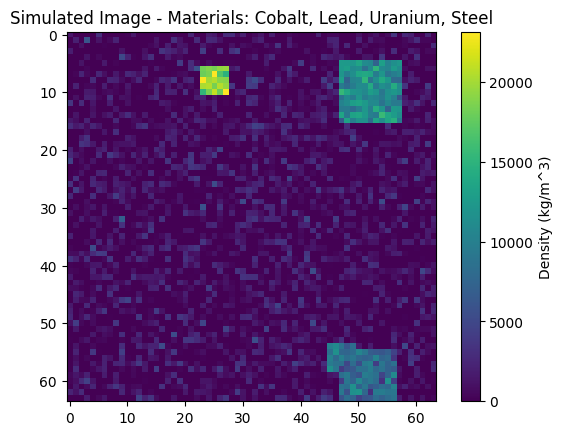

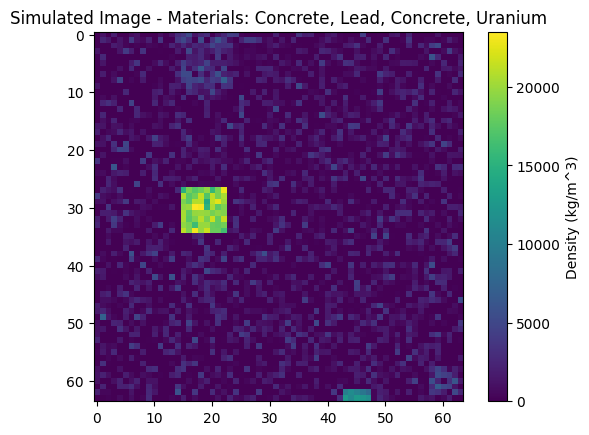

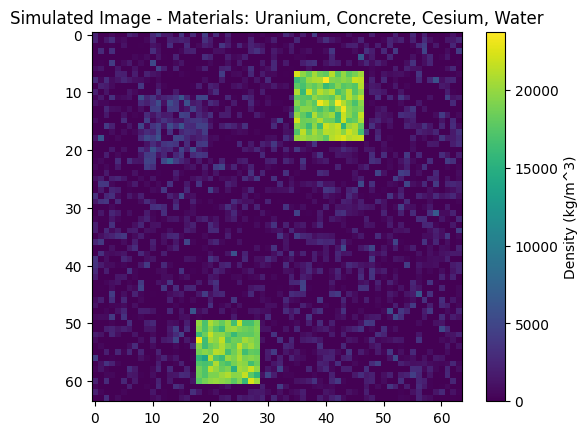

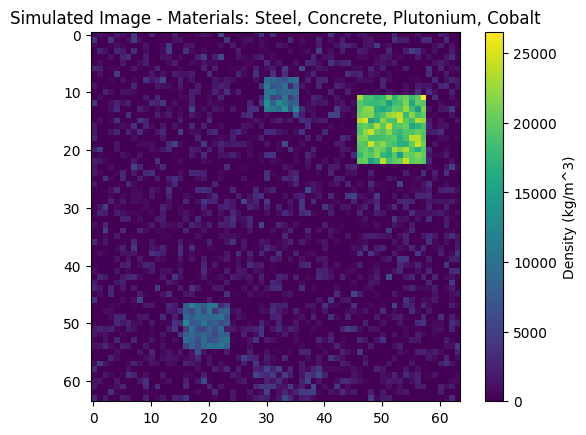

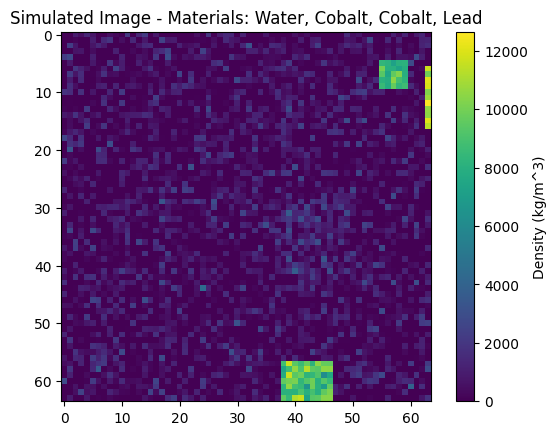

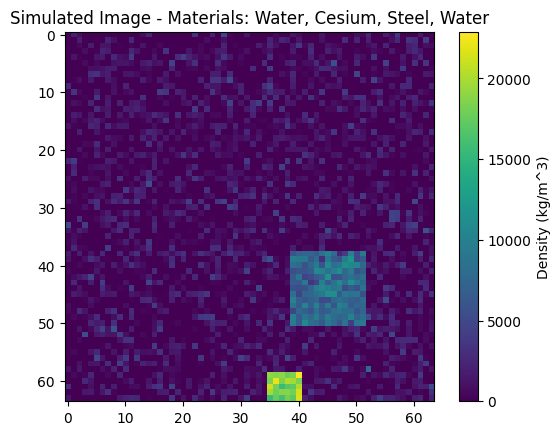

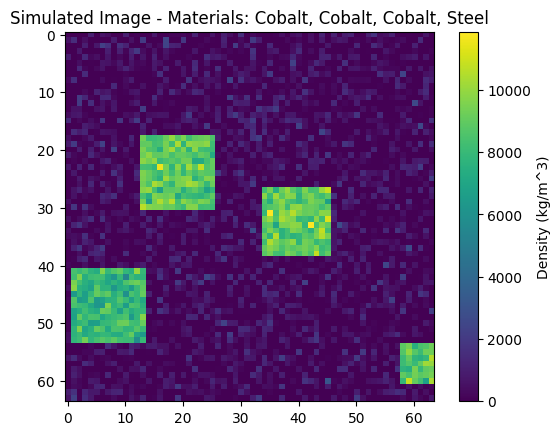

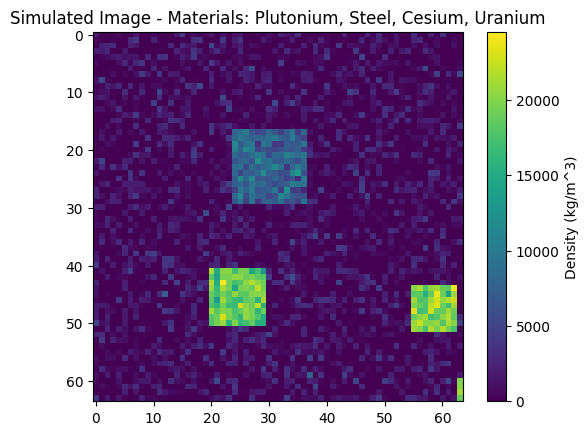

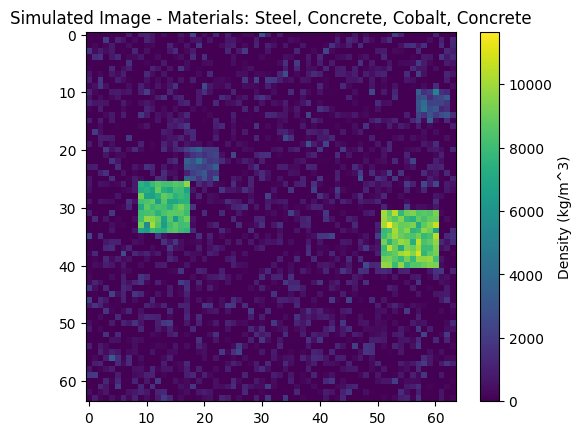

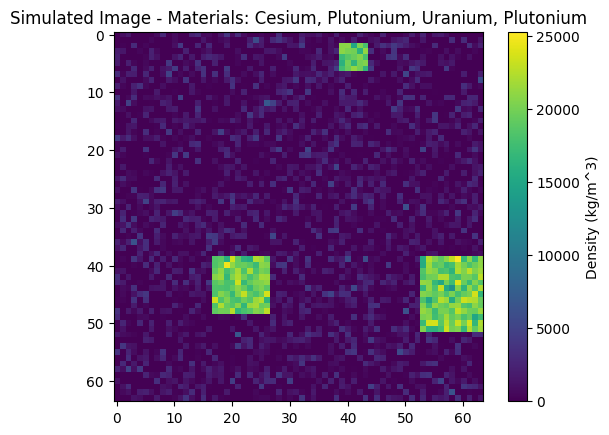

In [ ]:
import matplotlib.pyplot as plt

# Visualize augmented images from a Monte Carlo simulation
for i in range(min(10, len(X))):  # Display up to 10 images
    plt.figure()  # Create a new figure for each image
    plt.imshow(X[i].squeeze(), cmap='viridis')  # Display the image
    plt.colorbar(label='Density (kg/m^3)')  # Add colorbar
    plt.title(f"Simulated Image - Materials: {', '.join(y[i])}")  # Set title with materials
    plt.show()

In [ ]:
# Normalize the dataset
scaler = MinMaxScaler()
X_flattened = augmented_X.reshape(-1, 64 * 64)  # Flatten images
X_normalized_augmented = scaler.fit_transform(X_flattened).reshape(-1, 64, 64, 1)  # Reshape back to original dimensions


# Train/Test Split for Augmented Data
X_train_aug, X_test_aug, y_train_aug, y_test_aug = train_test_split(X_normalized_augmented, augmented_y, test_size=0.2, random_state=42)

# Remove the extra dimension
X_train_aug = X_train_aug.reshape(-1, 64, 64, 1)
X_test_aug = X_test_aug.reshape(-1, 64, 64, 1)


# Train CNN with Augmented Data
history_augmented = cnn_model.fit(X_train_aug, y_train_aug, epochs=10, batch_size=32, validation_data=(X_test_aug, y_test_aug), callbacks=[early_stopping])

# Evaluate Augmented CNN
augmented_loss, augmented_accuracy = cnn_model.evaluate(X_test_aug, y_test_aug)
print(f"Augmented CNN - Loss: {augmented_loss}, Accuracy: {augmented_accuracy}")

Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.0828 - loss: 202.0711 - val_accuracy: 0.1530 - val_loss: 100.8562
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.1322 - loss: 2214.2993 - val_accuracy: 0.4040 - val_loss: 77578.7109
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.1317 - loss: 162136.6719 - val_accuracy: 0.0020 - val_loss: 496701.7812
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1532 - loss: 100.5021
Augmented CNN - Loss: 100.85624694824219, Accuracy: 0.15299999713897705


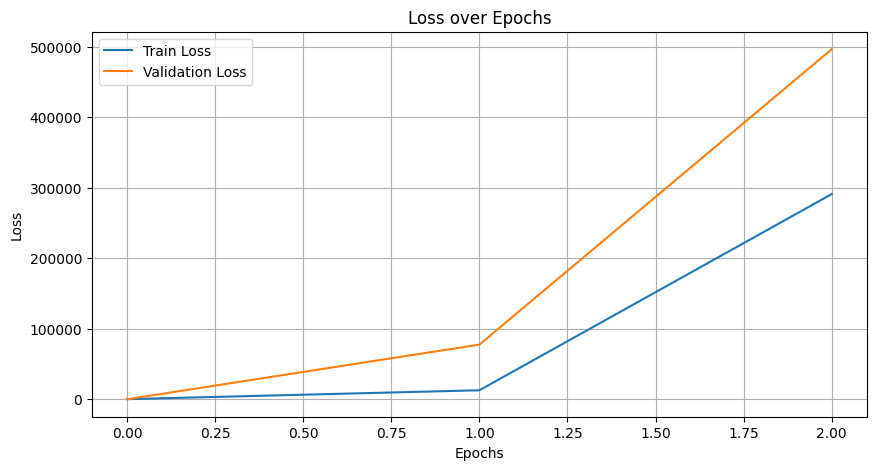

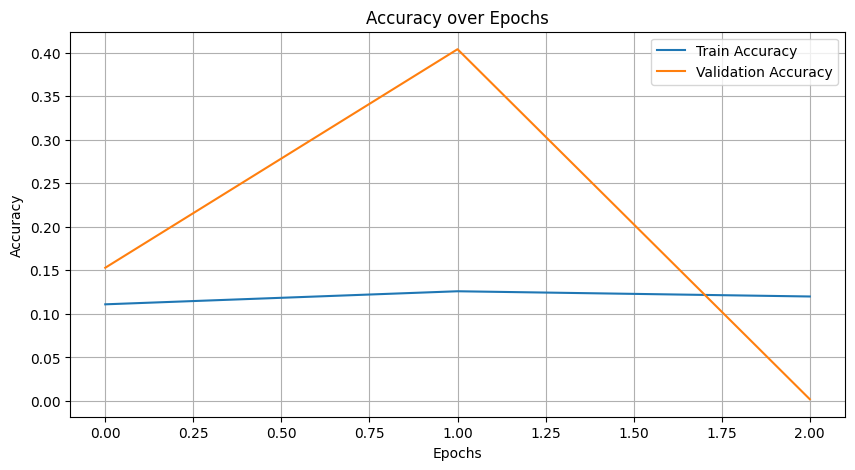

In [ ]:
# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(history_augmented.history['loss'], label='Train Loss')
plt.plot(history_augmented.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(history_augmented.history['accuracy'], label='Train Accuracy')
plt.plot(history_augmented.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()


# Scenario 2: Statistical methods

Extend the dataset to include synthetic labels generated via Poisson distribution, Markov chain models and survival analysis.

## Scenario 2.1: Poisson Distribution

In muon tomography, the flux of muons follows a Poisson distribution, meaning that the average number of muon detenctions follow a steady rate. However, there can be noise in this detections  that depends on the detector size, exposure time, and environmental factors. Therefore, for this exercise, I set a rate (𝜆) of detenction (with noise) as 5 based on a rough conversion made on the estimation of 100GeV per squared meter per second[1]. Assuming a pixel represents 0.01${m}^2$ and an exposure time of 0.5 seconds for taking the image, we have 100 * 0.01 * 0.5 = 0.5, and given that Poisson distributions work with discrete number of events (integers) I rounded this to 5 muons per pixel.


By incorporating Poisson noise to simulate real-world uncertainties in muon flux measurements, I intend to enhance the robustness of the model. By training with Poisson-augmented data, the CNN becomes more resilient to variability, improving its ability to generalize to experimental conditions. This method ensures the model reflects practical conditions, aligning it with the goals of muography for nuclear waste characterization.

[1] Muon imaging: principles, technologies and applications: https://www.researchgate.net/publication/319595716_Muon_imaging_Principles_technologies_and_applications

In [ ]:
import numpy as np
from scipy.stats import poisson
import tensorflow as tf

# Function for Poisson Augmentation
def poisson_augmentation(base_image, rate=5, size=10):
    """
    Generate augmented images with Poisson-distributed noise.

    Args:
        base_image: The original simulated image.
        rate: The average number of detections (with noise) per pixel.
        size: The number of augmented images to generate.

    Returns:
        List of augmented images.
    """
    augmented_images = []
    for _ in range(size):
        noise = poisson(rate).rvs(base_image.shape)
        augmented_images.append(np.clip(base_image + noise, 0, None))  # No negative densities
    return np.array(augmented_images)

# Generate Poisson Augmented Dataset
poisson_images, poisson_labels = [], []
for img, label in zip(X, y):
    poisson_augmented = poisson_augmentation(img, size=5)
    poisson_images.extend(poisson_augmented)
    poisson_labels.extend([label] * len(poisson_augmented))
poisson_images = np.array(poisson_images)[..., np.newaxis]
poisson_labels = np.array(poisson_labels)




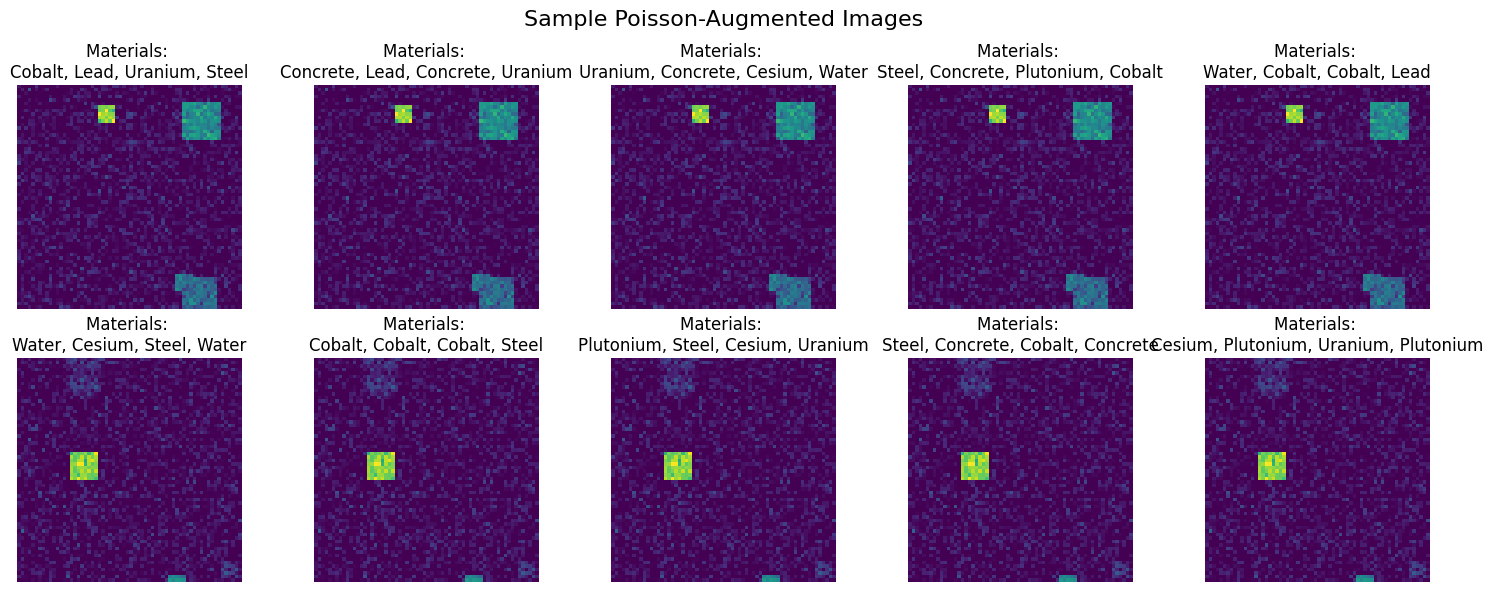

In [ ]:
# Display a few sample Poisson images:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))  # Create a 2x3 grid of subplots
fig.suptitle('Sample Poisson-Augmented Images', fontsize=16)

for i in range(10):  # Display 10 images
    row = i // 5
    col = i % 5
    axes[row, col].imshow(poisson_images[i].squeeze(), cmap='viridis')  # squeeze() to remove extra dimension
    axes[row, col].set_title(f"Materials: \n{', '.join(map(str, y[i]))}")  # Display labels
    axes[row, col].axis('off')  # Turn off axis ticks

plt.tight_layout()
plt.show()

In [ ]:
# Encode Poisson Labels (Material Types) for Classification
mlb = MultiLabelBinarizer()  # Create a new MultiLabelBinarizer instance
y_encoded_poisson = mlb.fit_transform(poisson_labels) # Use material list


# Normalize the dataset
scaler = MinMaxScaler()
X_flattened = poisson_images.reshape(-1, 64 * 64)  # Flatten images
X_normalized_poisson = scaler.fit_transform(X_flattened).reshape(-1, 64, 64, 1)  # Reshape back to original dimensions

# Update train/test split with normalized data
X_train_poisson, X_test_poisson, y_train_poisson, y_test_poisson = train_test_split(X_normalized_poisson, y_encoded_poisson, test_size=0.2, random_state=42)

# Set random seeds for reproducibility
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)


# Remove the extra dimension
X_train_poisson = X_train_poisson.reshape(-1, 64, 64, 1)
X_test_poisson = X_test_poisson.reshape(-1, 64, 64, 1)


# Train and Evaluate CNN with Poisson Data
history_poisson = cnn_model.fit(X_train_poisson, y_train_poisson, epochs=10, batch_size=32, validation_data=(X_test_poisson, y_test_poisson), callbacks=[early_stopping])

# Restore original scale for interpretation
predictions = cnn_model.predict(X_test_poisson)
# Evaluate Augmented CNN
poisson_loss, poisson_accuracy = cnn_model.evaluate(X_test_poisson, y_test_poisson)
print(f"Augmented CNN - Loss: {poisson_loss}, Accuracy: {poisson_accuracy}")

# Decode predicted labels
predicted_labels = mlb.inverse_transform((predictions > 0.5).astype(int))  # Convert probabilities to binary
for i, label in enumerate(predicted_labels[:10]):
    print(f"Image {i+1}: Predicted materials - {label}")

Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.0913 - loss: 2343.5288 - val_accuracy: 0.2850 - val_loss: 1484.1741
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.1204 - loss: 1358.2052 - val_accuracy: 0.0590 - val_loss: 725.3200
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.1032 - loss: 439.4340 - val_accuracy: 0.2360 - val_loss: 84.1077
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2826 - loss: 1521.6149
Augmented CNN - Loss: 1484.174072265625, Accuracy: 0.2849999964237213
Image 1: Predicted materials - ('Cesium',)
Image 2: Predicted materials - ('Cesium',)
Image 3: Predicted materials - ('Cesium',)
Image 4: Predicted materials - ('Steel',)
Image 5: Predicted materials - ('Cesium',)
Image 6: Predicted materials - ('Uranium',)
Image 7: Predicted materials - ('Uranium',)
Image 8: Predicted materials - ('Cesium',)
Image 9: Predicted materials - ('Cesium',)
Image 10: Predicted material

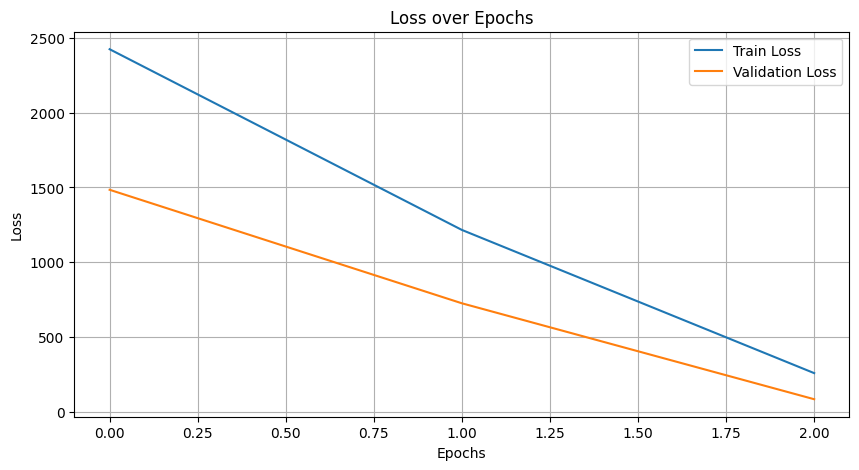

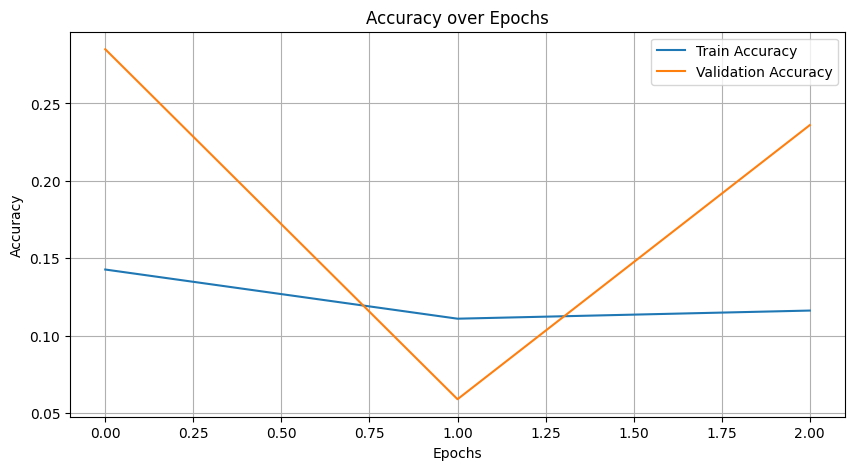

In [ ]:
# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(history_poisson.history['loss'], label='Train Loss')
plt.plot(history_poisson.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(history_poisson.history['accuracy'], label='Train Accuracy')
plt.plot(history_poisson.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()


## Scenario 2.2: Markov Chain

Markov Chains model the stochastic behavior (random and unpredicted) of radioactive materials, allowing us to:

- Capture layered shielding effects by defining transition probabilities between material layers or regions based on known material properties.
- Incorporate time-dependent decay properties of nuclear waste materials into CNN training data, enhancing the realism of predictions.

For example:

A muon passing through uranium might scatter in water, transition to lead shielding, and lose energy due to absorption in steel.

Based on this, we have the following model:

Let $\( S = \{ s_1, s_2, \ldots, s_n \} \$) be the set of material states (e.g., uranium, steel, lead). The transition probability matrix ( P ) is defined such that:



$\ P_{ij} = \text{Probability of transitioning from material } s_i \text{ to material } s_j \$



Example for a simplified system:



P = \begin{bmatrix}
1.0 & 0.0 & 0.0 & 0.0 \\
0.5 & 0.3 & 0.1 & 0.1 \\
0.6 & 0.2 & 0.1 & 0.1 \\
0.7 & 0.2 & 0.1 & 0.0
\end{bmatrix}



Row 1 ($( s_1 = \text{Empty Space} $)): Always remains empty. \\
Row 2 ($( s_2 = \text{Uranium} $)): Decays into other materials or interacts with surrounding layers. \\
Row 3 ($( s_3 = \text{Plutonium} $)): Similar decay or interaction. \\
Row 4 ($( s_4 = \text{Cesium} $)): Similar behavior.

At each timestep \( $t$ \), the state vector ( $x_t $) is updated as:



$[ x_{t+1} = x_t \cdot P $ ]



where ($ x_t $) is the current state distribution across all materials.

In [ ]:
import numpy as np
from joblib import Parallel, delayed


# Updated Transition Probabilities for Radioactive Materials
transition_probabilities = {
    # Radioactive materials: Transition probabilities based on decay and shielding
    19050: [0.5, 0.3, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0],   # Uranium:
        # - 0.5: Probability of staying as uranium
        # - 0.3: Transition to steel (muons scatter through steel layer in containment)
        # - 0.1: Transition to lead (muons interact with lead shielding)
        # - 0.1: Transition to water (muons scatter through moderating layer)
    19840: [0.6, 0.2, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0],   # Plutonium:
        # - 0.6: Probability of staying as plutonium
        # - 0.2: Transition to steel
        # - 0.1: Transition to lead
        # - 0.1: Transition to water
    18700: [0.7, 0.2, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0],   # Cesium:
        # - 0.7: Probability of staying as cesium
        # - 0.2: Transition to steel
        # - 0.1: Transition to lead
    8900: [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],    # Cobalt (assumed stable for this simulation)
}

def optimized_generate_markov_data_parallel(base_images, transition_probabilities, material_densities, size=10, n_jobs=-1):
    """
    Generate Markov Chain augmented dataset using parallel processing and vectorization.

    Args:
        base_images (np.array): Batch of base images.
        transition_probabilities (dict): Transition probabilities for materials.
        material_densities (dict): Material densities for mapping.
        size (int): Number of augmented images per base image.
        n_jobs (int): Number of parallel jobs (-1 for all available cores).

    Returns:
        np.array: Array of augmented images.
    """
    # Precompute material lists for faster access
    material_keys = np.array(list(material_densities.keys()))
    density_values = np.array(list(material_densities.values()))
    density_to_material = {v: k for k, v in material_densities.items()}

    def process_single_image(base_image):
        """
        Process a single image to generate augmented versions using Markov Chains.

        Args:
            base_image (np.array): Single base image.

        Returns:
            np.array: Array of augmented images.
        """
        augmented_images = []
        for _ in range(size):
            new_image = base_image.copy()

            # Vectorized pixel transition
            for i in range(base_image.shape[0]):
                for j in range(base_image.shape[1]):
                    # Set the material density for transition probabilities
                    current_density = base_image[i, j]

                    # Check if current density is in transition_probabilities
                    if current_density.item() in transition_probabilities:

                      # Sample material based on transition probabilities
                      next_material = np.random.choice(
                          material_keys,
                          p=transition_probabilities[current_density]
                      )
                      new_image[i, j] = material_densities[next_material]
                    else:
                        # If not found, pass
                        pass
            augmented_images.append(new_image)
        return np.array(augmented_images)

    # Parallel processing over the batch of images
    augmented_batches = Parallel(n_jobs=n_jobs)(
        delayed(process_single_image)(base_image) for base_image in base_images
    )

    # Combine results into a single array
    return np.vstack(augmented_batches)

# Use the optimized function (previously done with lists instead of array, therefore, the name of the function was changed to 'optimized')
markov_augmented_images = optimized_generate_markov_data_parallel(
    base_images=X,
    transition_probabilities=transition_probabilities,
    material_densities=material_densities,
    size=5,
    n_jobs=-1
)

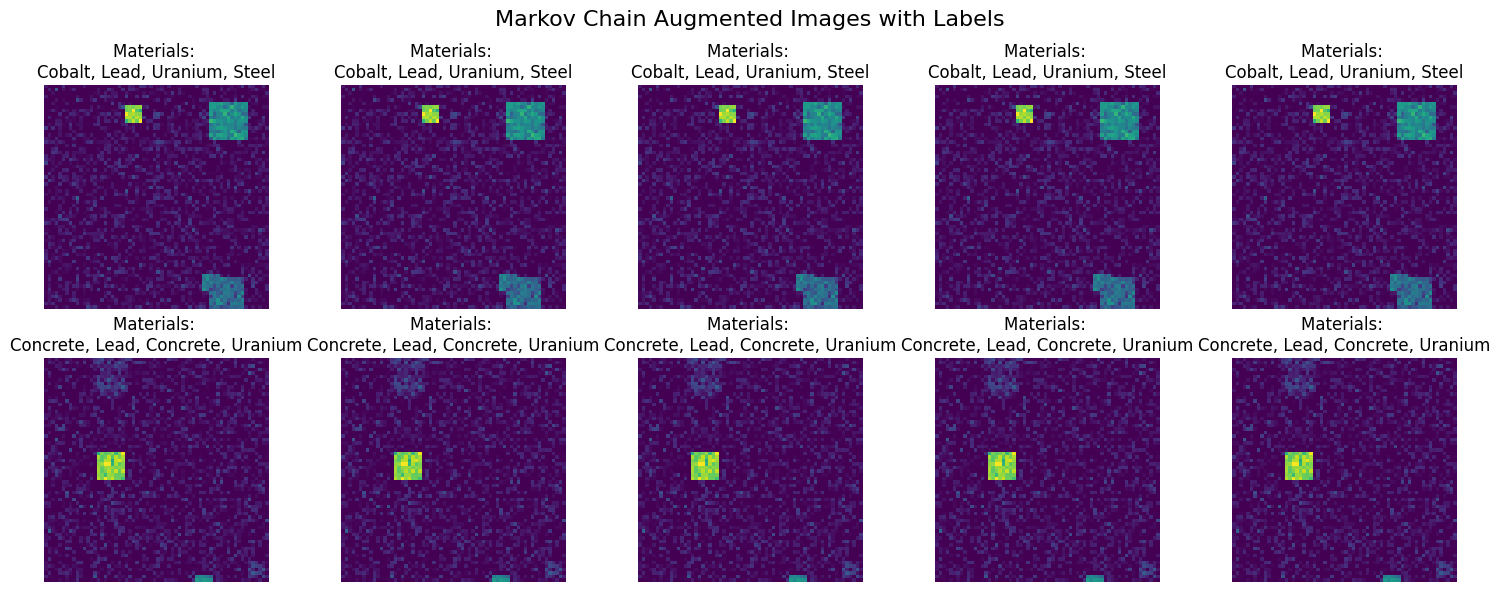

In [ ]:
import matplotlib.pyplot as plt

# Repeat labels to match augmented images
markov_labels_augmented = np.repeat(y, 5, axis=0)  # Repeat each label 5 times

# Visualize images with labels
num_images_to_display = 10  # Number of images to display

fig, axes = plt.subplots(2, 5, figsize=(15, 6))  # Adjust figsize as needed
fig.suptitle('Markov Chain Augmented Images with Labels', fontsize=16)

for i in range(num_images_to_display):
    row = i // 5
    col = i % 5
    axes[row, col].imshow(markov_augmented_images[i].squeeze(), cmap='viridis')
    axes[row, col].set_title(f"Materials: \n{', '.join(markov_labels_augmented[i])}")  # Display labels
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Normalize Markov Dataset
scaler = MinMaxScaler()
markov_images_flattened = markov_augmented_images.reshape(-1, 64 * 64)  # Flatten images
markov_images_normalized = scaler.fit_transform(markov_images_flattened).reshape(-1, 64, 64, 1)

# Encode Markov Labels (Material Types) for Classification
mlb_markov = MultiLabelBinarizer()  # Create a new MultiLabelBinarizer instance for Markov data
y_encoded_markov = mlb_markov.fit_transform(markov_labels_augmented) # Use material list


# Train/Test Split for normalized Markov Data
X_train_markov, X_test_markov, y_train_markov, y_test_markov = train_test_split(
    markov_images_normalized, y_encoded_markov, test_size=0.2, random_state=42
)

# Train and Evaluate CNN with Markov Data
history_markov = cnn_model.fit(
    X_train_markov, y_train_markov, epochs=10, batch_size=32, validation_data=(X_test_markov, y_test_markov), callbacks=[early_stopping]
)

# Evaluate the Markov CNN
markov_loss, markov_accuracy = cnn_model.evaluate(X_test_markov, y_test_markov)
print(f"Markov Chain Augmented CNN - Loss: {markov_loss}, Accuracy: {markov_accuracy}")

# Visualize Predicted Labels
predictions_markov = cnn_model.predict(X_test_markov)
predicted_labels_markov = mlb.inverse_transform((predictions_markov > 0.5).astype(int))
for i, label in enumerate(predicted_labels_markov[:10]):
    print(f"Image {i+1}: Predicted materials - {label}")


Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.1324 - loss: 1486.2734 - val_accuracy: 0.1530 - val_loss: 1368.4459
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.1192 - loss: 1301.5714 - val_accuracy: 0.1580 - val_loss: 972.0336
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.1154 - loss: 783.5327 - val_accuracy: 0.0220 - val_loss: 96.8159
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1425 - loss: 1404.9243
Markov Chain Augmented CNN - Loss: 1368.4459228515625, Accuracy: 0.15299999713897705
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Image 1: Predicted materials - ('Water',)
Image 2: Predicted materials - ('Cesium',)
Image 3: Predicted materials - ('Concrete',)
Image 4: Predicted materials - ('Steel',)
Image 5: Predicted materials - ('Cesium',)
Image 6: Predicted materials - ('Lead',)
Image 7: Predicted materials - ('Uranium',)
Image 8: Predicted materials - ('Plutonium',)
Image 9: Predicted materials - ('Cesium',)
Image 10: Pre

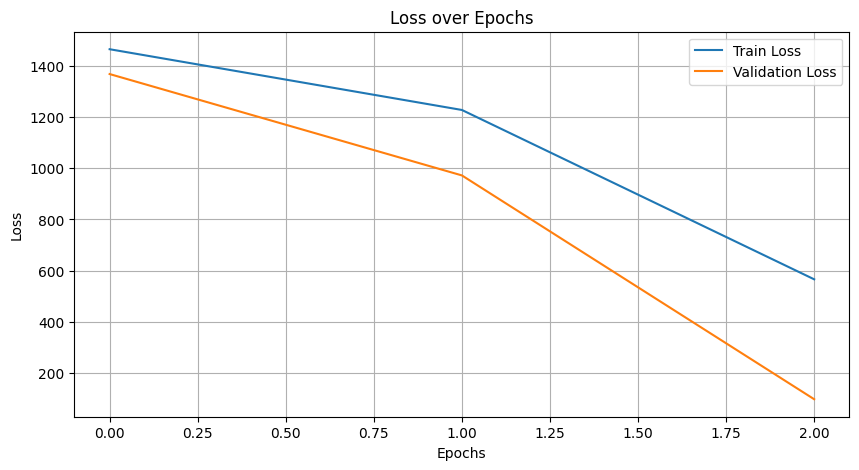

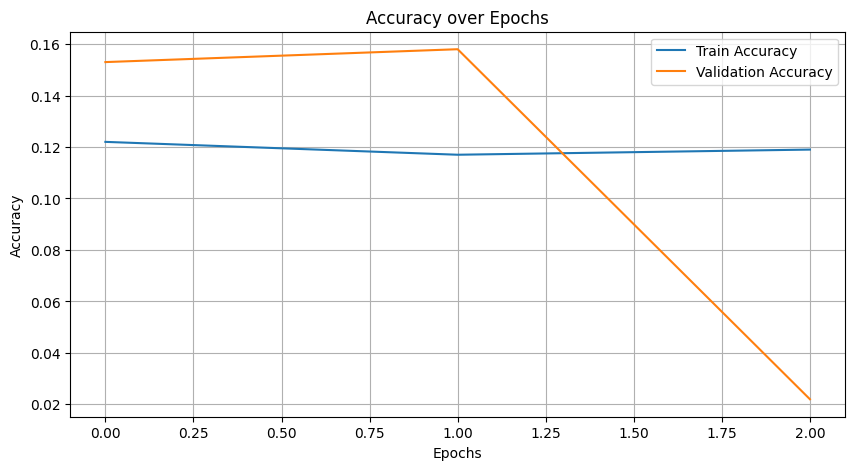

In [ ]:
# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(history_markov.history['loss'], label='Train Loss')
plt.plot(history_markov.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(history_markov.history['accuracy'], label='Train Accuracy')
plt.plot(history_markov.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()


## Scenario 2.3: Survival Analysis

Survival analysis focuses on the time until an event occurs, such as the transition of a muon through a material. For this use case, I simulate the survival times of muons as they traverse different materials inside containers. The survival times are modeled using an exponential distribution, which is common for decay processes.

The survival time is modeled as the time a muon spends in a material before transitioning to another. The rate parameter (𝜆) for each material is related to its density and interaction properties.

λ (Rate Parameter):

Represents the likelihood of a muon transitioning to another material or being absorbed within the material.
Higher rates (𝜆) indicate faster interactions or transitions (e.g., radioactive decay, denser materials).

The survival time (t) of a muon in a material is modeled using the exponential distribution, given by the probability density function (PDF):

$𝑓(𝑡)=𝜆𝑒^{−𝜆𝑡}$

where:

- $f(t)$ = the probability density function (PDF) of the survival time
- 𝜆 = the rate parameter, representing the likelihood of a transition or absorption
- 𝑡 = the time until the muon transitions.

In order to model the interaction of materials, where higher rates implies a shorter interaction, I used an inverse relationship where the **interaction time** (τ) = 1/𝜆 is defined by 𝜆 = 1/τ that represents the average interaction time of a muon with the materail, so denser materials like uranium would have higher 𝜆 values for faster interactions and thus, shorter interaction times. Substituting this relationship into the exponential distribution formula, we obtain:


$f(𝑡) =  (1/τ)𝑒^{(-𝑡/τ)}$

where:

- f(𝑡) = PDF of survival time
- τ = average interaction time of the muon with the material
- 𝑡 = the survival time unitl the muon transitions.

By doing this, now the PDF represents the probability of a muon surviving for a time (𝑡), given its average interaction time (τ) with the material.Therefore, higher values of τ, represent a lower probability of a transition ocurring within a short time and vice versa.

By applying this, it is expected to improve predictions by providing time-resolved data that enhance the CNN's ability to predict material properties based on muon interaction patterns.

Note: For this notebook I'll use placeholders for the interaction times to speed up the production process of this notebook, since there are different factors to consider such as density of the materials used in the simulation and their respective atomic numbers, or even radioactive decay of particles. Also, consulting external sources could be beneficial such as that of the Particle Data Group (PDG): https://pdg.lbl.gov/2021/reviews/rpp2020-rev-passage-particles-matter.pdf

In [ ]:
# install Kaplan-Meier library
! pip install lifelines

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 12.8 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4031 sha256=44d4cfb79266f0a2e53c8cef47df0cfe8cf85e0db05a178a81fd959b389594cc
  Stored in directory: /root/.cache/pip/wheels/25/cc/e0/ef2969164144c899fedb22b338f6703e2b9cf46eeebf254991
Successfully built autograd-gamma


In [ ]:
from joblib import Parallel, delayed
import random
from scipy.stats import expon

def generate_survival_times_optimized(base_image, rates):
    """
    Generate augmented images with survival times using vectorized operations for faster performance.

    Args:
        base_image (np.array): Single base image.
        rates (dict): Material rates for mapping.

    Returns:
        np.array: Array of augmented images with survival times.

    """
    # Get material densities and their corresponding rates
    material_values = np.array(list(material_densities.values()))
    rate_values = np.array([rates[material] for material in material_densities.keys()])

    # Compute the absolute differences for each pixel against all material densities
    differences = np.abs(base_image[..., None] - material_values[None, None, :])

    # Find the index of the closest material for each pixel
    closest_material_indices = np.argmin(differences, axis=-1)


    # Map the closest material indices to rates
    closest_rates = rate_values[closest_material_indices]


    # Generate survival times based on the identified rates
    survival_image = expon(scale=1 / closest_rates).rvs(size=base_image.shape)

    return survival_image


# Parallel Survival Data Augmentation
def parallel_survival_augmentation(images, rates, num_augmentations=5):
    """
    Generate augmented survival images in parallel.

    Args:
        images (np.array): Batch of base images.
        rates (dict): Material rates for mapping.
        num_augmentations (int): Number of augmented images per base image.

    Returns: Array of augmented images

    """
    def augment_image(img):
        """
        Augment a single image with survival times.

        Args:
            img (np.array): Single base image.

        Returns:
            np.array: Augmented image with survival times.
        """
        return [generate_survival_times_optimized(img, rates) for _ in range(num_augmentations)]

    augmented_images = Parallel(n_jobs=-1)(delayed(augment_image)(img) for img in images)
    return np.concatenate(augmented_images)

In [ ]:
from joblib import Parallel, delayed
import random
from scipy.stats import expon
import matplotlib.pyplot as plt


# Define survival rate (lambda) for materials based on density and interaction properties
survival_rates = {
    "Steel": 0.002,     # High density, moderate interaction
    "Lead": 0.003,      # Higher density, greater interaction
    "Concrete": 0.001,  # Lower density, less interaction
    "Water": 0.0005,    # Minimal interaction
    "Uranium": 0.01,    # High density, radioactive material
    "Plutonium": 0.015, # Even higher interaction rate
    "Cesium": 0.008,    # Medium interaction rate
    "Cobalt": 0.005,    # Moderate interaction rate
}

# Generate Survival Images for Visualization
survival_images = parallel_survival_augmentation(X, survival_rates, num_augmentations=5)




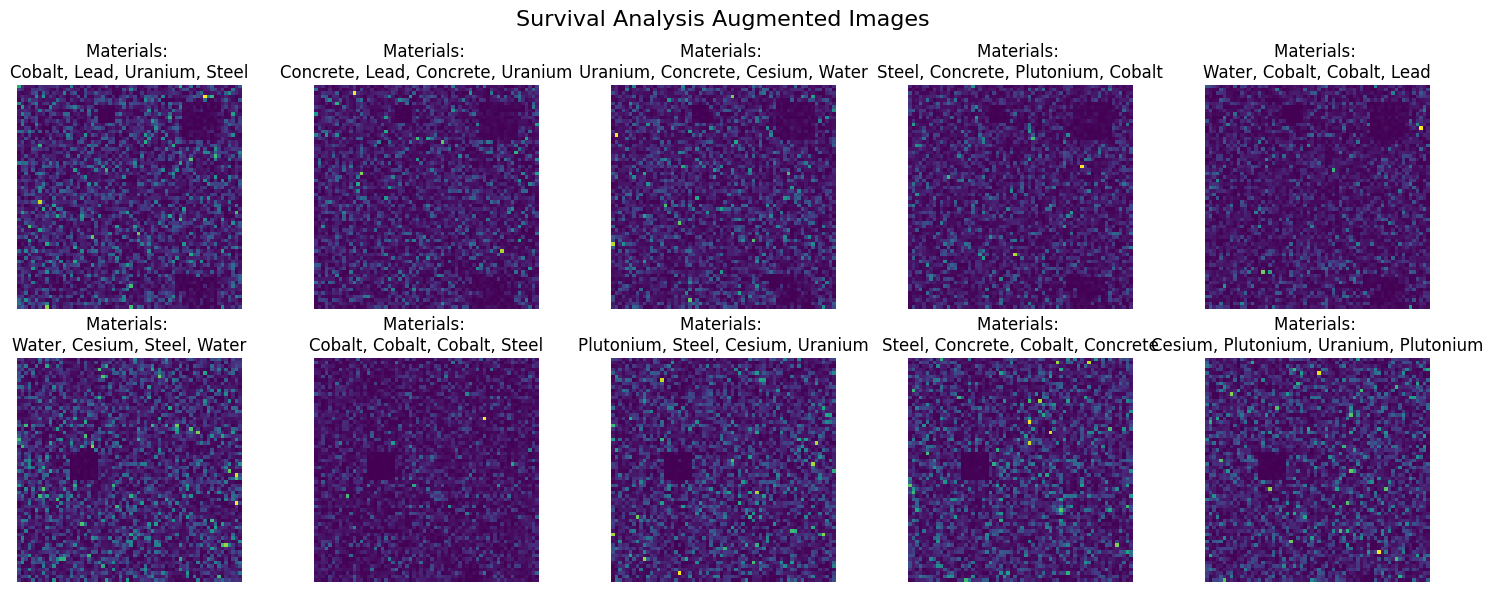

In [ ]:

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Survival Analysis Augmented Images', fontsize=16)

# Use nested loops to access the axes array properly
for i in range(2):  # Loop through rows
    for j in range(5):  # Loop through columns
        index = i * 5 + j  # Calculate the index for the survival_images array
        if index < len(survival_images):  # Check if we have more images to display
            axes[i, j].imshow(survival_images[index].squeeze(), cmap='viridis')
            axes[i, j].set_title(f"Materials: \n{', '.join(map(str, y[index]))}")
            axes[i, j].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Encode Labels (Material Types) for Classification
mlb = MultiLabelBinarizer()
y_encoded = mlb.fit_transform(y)

# Normalize Survival Data for CNN Input
scaler = MinMaxScaler()
survival_images_flat = survival_images.reshape(-1, 64 * 64) # flat images
survival_images_normalized = scaler.fit_transform(survival_images_flat).reshape(-1, 64, 64, 1)

# Repeat labels to match the augmented images
y_encoded_repeated = np.repeat(y_encoded, 5, axis=0)  # Repeat each label 5 times

# Train/Test Split for Survival Data
X_train_survival, X_test_survival, y_train_survival, y_test_survival = train_test_split(
    survival_images_normalized, y_encoded_repeated, test_size=0.2, random_state=42
)

# Train CNN with Survival Data
history_survival = cnn_model.fit(
    X_train_survival, y_train_survival, epochs=10, batch_size=32, validation_data=(X_test_survival, y_test_survival), callbacks=[early_stopping]
)

# Evaluate CNN with Survival Data
survival_loss, survival_accuracy = cnn_model.evaluate(X_test_survival, y_test_survival)
print(f"Survival Analysis CNN - Loss: {survival_loss}, Accuracy: {survival_accuracy}")

# Print Predictions
predictions = cnn_model.predict(X_test_survival)
predicted_labels = mlb.inverse_transform((predictions > 0.5).astype(int))
actual_labels = mlb.inverse_transform((y_test_survival > 0.5).astype(int))

for i, label in enumerate(predicted_labels[:10]):
    print(f"Image {i+1}: Predicted materials - {label}")

Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.0882 - loss: 1643.2247 - val_accuracy: 0.1480 - val_loss: 1232.2684
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.0978 - loss: 972.5059 - val_accuracy: 0.1580 - val_loss: 256.1839
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.1351 - loss: 268.3843 - val_accuracy: 0.0140 - val_loss: 448.9448
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1406 - loss: 1271.4025
Survival Analysis CNN - Loss: 1232.2684326171875, Accuracy: 0.14800000190734863
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Image 1: Predicted materials - ('Concrete',)
Image 2: Predicted materials - ('Concrete',)
Image 3: Predicted materials - ('Lead',)
Image 4: Predicted materials - ('Concrete',)
Image 5: Predicted materials - ('Concrete',)
Image 6: Predicted materials - ('Concrete',)
Image 7: Predicted materials - ('Concrete',)
Image 8: Predicted materials - ('Concrete',)
Image 9: Predicted materials - ('Lead',)
Image 1

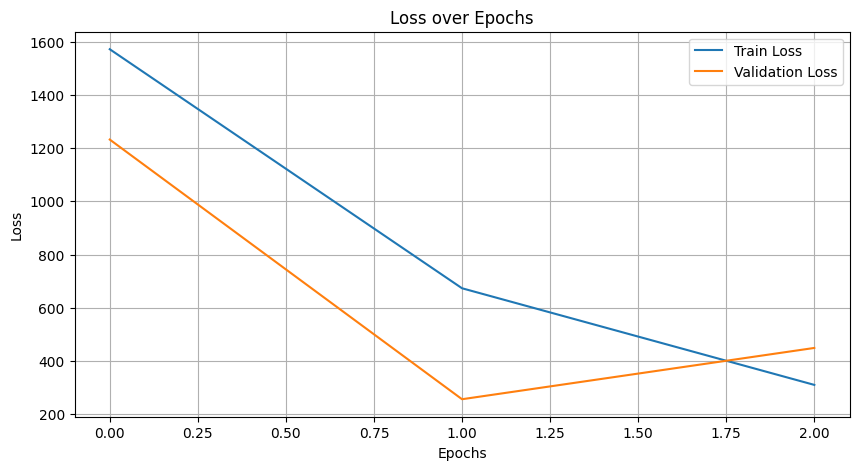

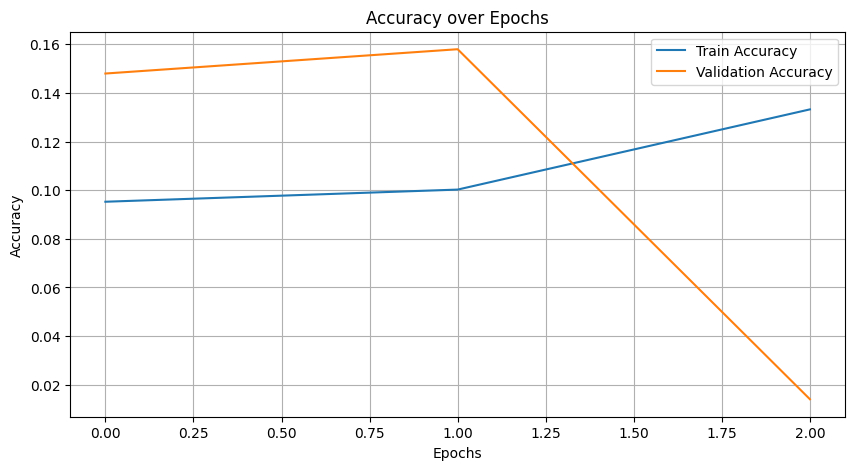

In [ ]:
# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(history_survival.history['loss'], label='Train Loss')
plt.plot(history_survival.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(history_survival.history['accuracy'], label='Train Accuracy')
plt.plot(history_survival.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()


# Zonotopic Dempster Shafer Structures

Zonotopic Dempster-Shafer Structures (DSZ) is a framework that combines the principles of Dempster-Shafer Theory (DST) with zonotopic representations to model and manage uncertainty in data. This approach offers a robust and flexible way to represent uncertainty, particularly in situations where data is imprecise, incomplete, or conflicting.

Dempster-Shafer Theory (DST):

DST provides a framework for reasoning with uncertainty by assigning degrees of belief to different propositions or hypotheses. These degrees of belief are represented by a mass function ($m$), which is defined over the set of all possible outcomes. The mass function assigns a value between 0 and 1 to each subset, indicating the degree of belief (maximum confidence probability) that the true outcome lies within that subset.

Two key measures in DST are belief (Bel) and plausibility (Pl):

Belief (Bel): Represents the total belief that directly supports a proposition ($A$). It is calculated as the sum of the masses assigned to all subsets of $A$:

$$Bel(A) = \sum_{B \subseteq A} m(B)$$
Plausibility (Pl): Represents the total belief that does not contradict a proposition ($A$). It is calculated as the sum of the masses assigned to all subsets that have at least some overlap with $A$:

$$Pl(A) = \sum_{B \cap A \neq \emptyset} m(B)$$

Zonotopes:

Zonotopes are geometric shapes used to represent sets of points in a high-dimensional space. They are defined by a center point and a set of generators. In the context of uncertainty representation, zonotopes provide a way to enclose a range of possible values, capturing the uncertainty associated with a particular quantity or parameter.

DSZ Framework:

The DSZ framework integrates DST and zonotopes by using zonotopes to represent the uncertainty associated with the belief and plausibility values derived from the mass function. This is achieved by calculating the center and bounds of the probabilistic zonotope. The center is computed as the cumulative sum of masses, while the bounds are equivalent to the mass function values after adjustments.

The probabilistic zonotope provides a framework to handle the uncertainty associated with the belief and plausibility, by utilizing a set of probabilistic generators of the CNN. The generators reflect the range of possible outcomes and variability in experimental data such as noise when capturing muogrpahy images.

By adjusting the belief and plausibility with a 0.5 offset for vectorized calculations, a system is created to directly utilize the values of belief and plausibility in the calculations of the zonotope and its probabilistic generators, ensuring that the probability distribution of the original data is preserved.

Key Advantages of DSZ:

- Robust Uncertainty Representation: DSZ provides a robust way to represent uncertainty, taking into account both belief and plausibility.

- Flexibility: Zonotopes can represent different types of uncertainty, including aleatoric (from the data) and epistemic (from the model) uncertainty.

- Computational Efficiency: DSZ offers efficient methods for propagating uncertainty through complex systems.

So, by utilizing this framework, I aim to train a more robust model capable of capturing noise from data and make better predictions.

In [ ]:
import numpy as np
from concurrent.futures import ThreadPoolExecutor

def calculate_belief_and_plausibility_vectorized(mass_function):
    """
    Vectorized computation of belief and plausibility from mass functions.

    Args:
        mass_function (np.array): Normalized mass functions for each image.

    Returns:
        tuple: Belief and plausibility arrays for all images.
    """
    cumsum_mass = np.cumsum(mass_function, axis=-1)
    belief = cumsum_mass - 0.5 * mass_function
    plausibility = cumsum_mass + 0.5 * mass_function
    return belief, plausibility

def create_probabilistic_generators_vectorized(center, bounds, num_generators=3, noise_std=0.1):
    """
    Create probabilistic generators for a zonotope using vectorized operations.

    Args:
        center (np.array): Array of center values for DSZ.
        bounds (np.array): Array of bounds values for DSZ.
        num_generators (int): Number of generators for the probabilistic zonotope.
        noise_std (float): Standard deviation for noise scaling.

    Returns:
        np.array: Probabilistic zonotope with generators stacked along the last axis.
    """
    noise = np.random.normal(0, noise_std, (center.shape[0], center.shape[1], center.shape[2],1, num_generators))

    # Reshape center and bounds to match noise dimensions for broadcasting
    center_expanded = center[..., np.newaxis]
    bounds_expanded = bounds[..., np.newaxis]

    # Perform the operation with broadcasting
    generators = center_expanded + bounds_expanded * noise

    return generators

def create_dsz_data_parallel(X, num_generators=3, noise_std=0.1):
    """
    Create DSZ-enhanced dataset with parallelization and vectorized computations.

    Args:
        X (np.array): Input dataset (grayscale images).
        num_generators (int): Number of generators for probabilistic zonotopes.
        noise_std (float): Standard deviation for noise scaling.

    Returns:
        np.array: DSZ-enhanced dataset with center, bounds, and probabilistic uncertainty.
    """
    # Flatten images and normalize to create mass functions
    flattened_images = X.reshape(X.shape[0], -1)
    mass_functions = flattened_images / np.sum(flattened_images, axis=-1, keepdims=True)

    # Calculate belief and plausibility
    belief, plausibility = calculate_belief_and_plausibility_vectorized(mass_functions)

    # Reshape belief and plausibility to match input dimensions
    belief = belief.reshape(X.shape)
    plausibility = plausibility.reshape(X.shape)

    # Compute DSZ center and bounds
    dsz_centers = (belief + plausibility) / 2
    dsz_bounds = (plausibility - belief) / 2

    # Generate probabilistic generators
    probabilistic_generators = create_probabilistic_generators_vectorized(dsz_centers, dsz_bounds, num_generators, noise_std)

    # Aggregate probabilistic uncertainty (mean of generators)
    uncertainty_representation = probabilistic_generators.mean(axis=-1)

    # Combine original data, DSZ center, and uncertainty representation
    dsz_data = np.concatenate([X, dsz_centers, uncertainty_representation], axis=-1)

    return dsz_data

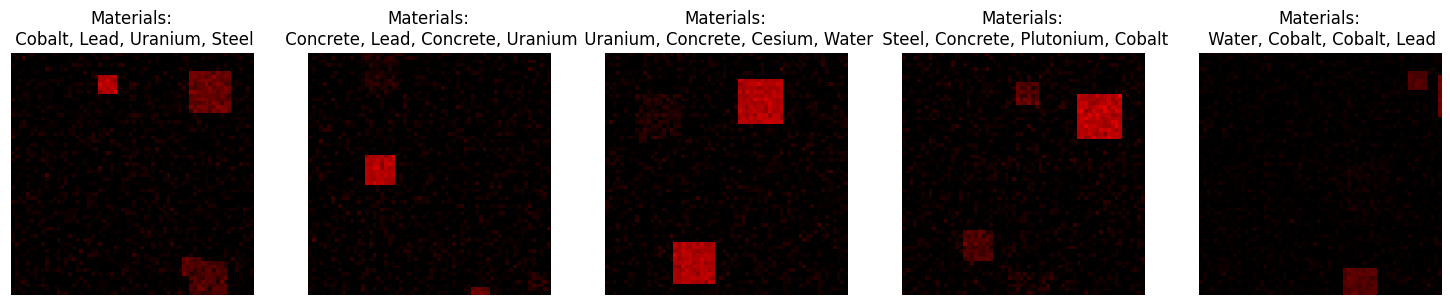

In [ ]:
# Generate DSZ Data
X_dsz = create_dsz_data_parallel(X, num_generators=3, noise_std=0.0)

# Scale data to 0-255 range to compact all the information of the original data,
# the centers and the uncertainity into one image with correct contrast and brightness
scaled_X_dsz = (X_dsz - np.min(X_dsz)) / (np.max(X_dsz) - np.min(X_dsz)) * 255
scaled_X_dsz = scaled_X_dsz.astype(np.uint8)  # Convert to uint8 for RGB

# Display the first few samples in a grid
num_samples_to_display = 5

# Create a figure and subplots
fig, axes = plt.subplots(1, num_samples_to_display, figsize=(15, 3))

# Iterate and display images on subplots
for i, ax in enumerate(axes):
    ax.imshow(scaled_X_dsz[i])
    ax.set_title(f"Materials:\n {', '.join(y[i])}")
    ax.axis('off')  # Turn off axis ticks and labels

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
y_reshaped = np.array(y)  # Convert y to a NumPy array

# Encode the labels for multi-label classification
mlb = MultiLabelBinarizer()
y_encoded = mlb.fit_transform(y_reshaped)  # Encode the labels using MultiLabelBinarizer

scaler = MinMaxScaler()
dsz_images_flat = X_dsz.reshape(-1, 64 * 64)
dsz_images_normalized = scaler.fit_transform(dsz_images_flat).reshape(-1, 64, 64, 3)

# Repeat labels to match the augmented images
y_encoded_repeated = np.repeat(y_encoded, dsz_images_normalized.shape[0] // y_encoded.shape[0], axis=0)  # Repeat each label 5 times

# Train/Test Split for DSZ Data
X_train_dsz, X_test_dsz, y_train_dsz, y_test_dsz = train_test_split(
    dsz_images_normalized, y_encoded_repeated, test_size=0.2, random_state=42)


cnn_model_dsz = create_model(input_shape=(64, 64, 3))  # DSZ has 3 channels now (X, center, uncertainty)

# Train CNN with DSZ Data
history_dsz = cnn_model_dsz.fit(X_train_dsz, y_train_dsz, epochs=10, batch_size=32, validation_data=(X_test_dsz, y_test_dsz), callbacks=[early_stopping])

# Evaluate CNN
dsz_loss, dsz_accuracy = cnn_model_dsz.evaluate(X_test_dsz, y_test_dsz)
print(f"DSZ Analysis CNN - Loss: {dsz_loss}, Accuracy: {dsz_accuracy}")

# Print Predictions
predictions = cnn_model_dsz.predict(X_test_dsz)
predicted_labels = mlb.inverse_transform((predictions > 0.5).astype(int))
actual_labels = mlb.inverse_transform((y_test_dsz > 0.5).astype(int))

for i, label in enumerate(predicted_labels[:10]):
    print(f"Image {i+1}: Predicted materials - {label}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 247ms/step - accuracy: 0.0596 - loss: 9.7948 - val_accuracy: 0.1850 - val_loss: 40.6590
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.1616 - loss: 82.8939 - val_accuracy: 0.3950 - val_loss: 181.7630
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1677 - loss: 315.5634 - val_accuracy: 0.3000 - val_loss: 504.2452
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1683 - loss: 41.5633 
DSZ Analysis CNN - Loss: 40.658958435058594, Accuracy: 0.1850000023841858
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Image 1: Predicted materials - ('Water',)
Image 2: Predicted materials - ()
Image 3: Predicted materials - ()
Image 4: Predicted materials - ()
Image 5: Predicted materials - ()
Image 6: Predicted materials - ('Water',)
Image 7: Predicted materials - ('Cesium',)
Image 8: Predicted materials - ('Water',)
Image 9: Predicted materials - ('Cesium',)
Image 10: Predicted materials - ('Water',)


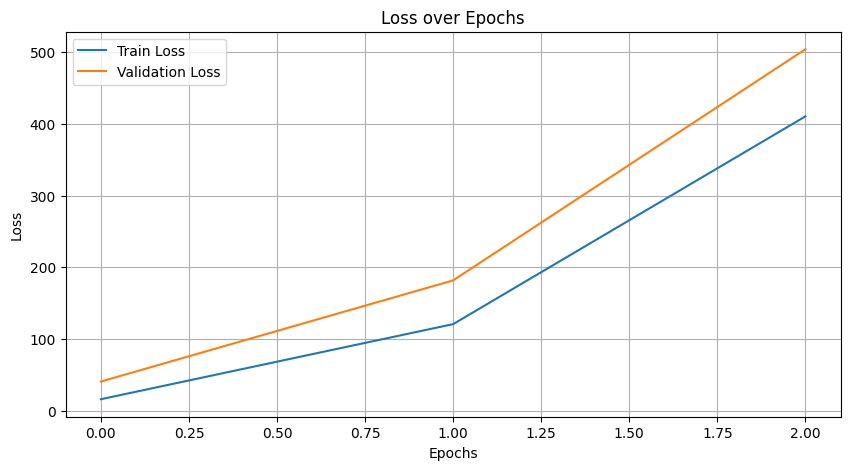

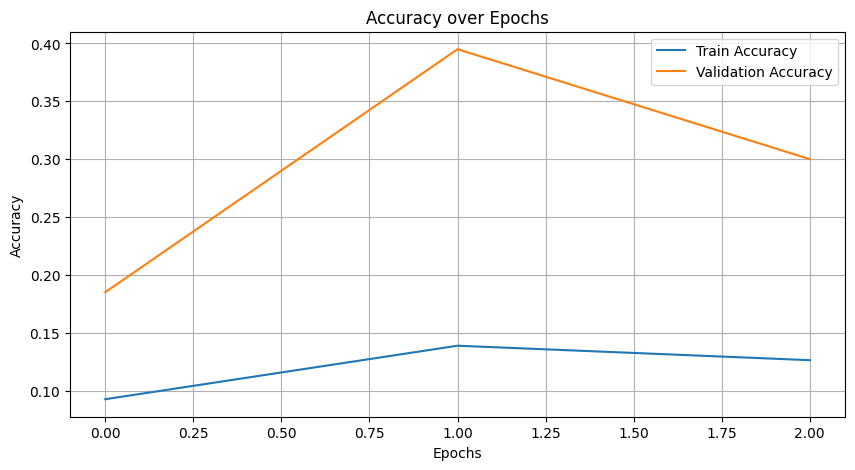

In [ ]:
# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(history_dsz.history['loss'], label='Train Loss')
plt.plot(history_dsz.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(history_dsz.history['accuracy'], label='Train Accuracy')
plt.plot(history_dsz.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()


## DSZ with survival analysis data

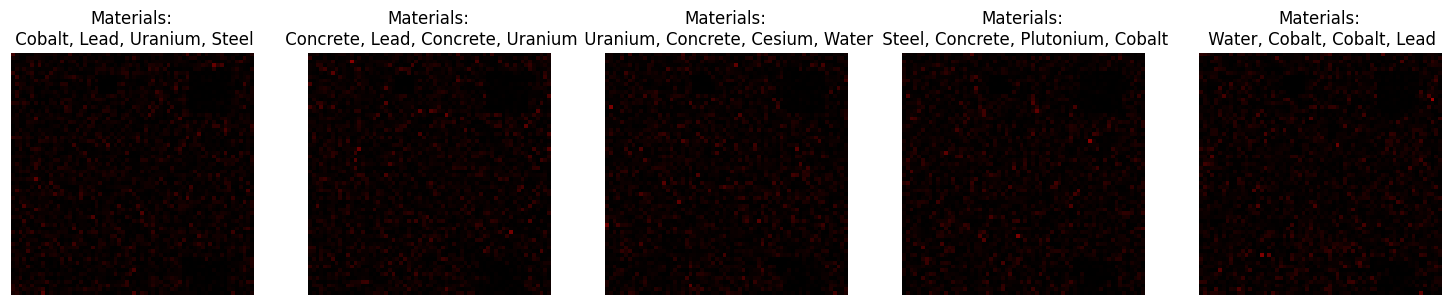

In [ ]:
# Generate DSZ Data using survival analysis generated images
X_dsz = create_dsz_data_parallel(survival_images, num_generators=3, noise_std=0.0)

# Scale data to 0-255 range
scaled_X_dsz = (X_dsz - np.min(X_dsz)) / (np.max(X_dsz) - np.min(X_dsz)) * 255
scaled_X_dsz = scaled_X_dsz.astype(np.uint8)  # Convert to uint8 for RGB

# Display the first few samples in a grid
num_samples_to_display = 5

# Create a figure and subplots
fig, axes = plt.subplots(1, num_samples_to_display, figsize=(15, 3))

# Iterate and display images on subplots
for i, ax in enumerate(axes):
    ax.imshow(scaled_X_dsz[i])
    ax.set_title(f"Materials:\n {', '.join(y[i])}")
    ax.axis('off')  # Turn off axis ticks and labels

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
y_reshaped = np.array(y)  # Convert y to a NumPy array

# Encode the labels for multi-label classification
mlb = MultiLabelBinarizer()
y_encoded = mlb.fit_transform(y_reshaped)  # Encode the labels using MultiLabelBinarizer

scaler = MinMaxScaler()
dsz_images_flat = X_dsz.reshape(-1, 64 * 64)
dsz_images_normalized = scaler.fit_transform(dsz_images_flat).reshape(-1, 64, 64, 3)

# Repeat labels to match the augmented images
y_encoded_repeated = np.repeat(y_encoded, dsz_images_normalized.shape[0] // y_encoded.shape[0], axis=0)  # Repeat each label 5 times

# Train/Test Split for DSZ Data
X_train_dsz, X_test_dsz, y_train_dsz, y_test_dsz = train_test_split(
    dsz_images_normalized, y_encoded_repeated, test_size=0.2, random_state=42)

cnn_model_dsz = create_model(input_shape=(64, 64, 3))  # DSZ has 3 channels now (X, center, uncertainty)

# Train CNN with survival Data
history_dsz_survival_data = cnn_model_dsz.fit(X_train_dsz, y_train_dsz, epochs=10, batch_size=32, validation_data=(X_test_dsz, y_test_dsz), callbacks=[early_stopping])

# Evaluate CNN with Survival Data
dsz_loss_survival, dsz_accuracy_survival = cnn_model_dsz.evaluate(X_test_dsz, y_test_dsz)
print(f"DSZ Analysis CNN for survival analysis images - Loss: {dsz_loss_survival}, Accuracy: {dsz_accuracy_survival}")

# Print Predictions
predictions = cnn_model_dsz.predict(X_test_dsz)
predicted_labels = mlb.inverse_transform((predictions > 0.5).astype(int))
actual_labels = mlb.inverse_transform((y_test_dsz > 0.5).astype(int))

for i, label in enumerate(predicted_labels[:10]):
    print(f"Image {i+1}: Predicted materials - {label}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.1175 - loss: 411.0130 - val_accuracy: 0.0370 - val_loss: 8847.9570
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.1140 - loss: 28689.9863 - val_accuracy: 0.4210 - val_loss: 95152.4453
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.1231 - loss: 230123.2344 - val_accuracy: 0.2820 - val_loss: 594046.4375
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0334 - loss: 8737.2295
DSZ Analysis CNN for survival analysis images - Loss: 8847.95703125, Accuracy: 0.03700000047683716
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Image 1: Predicted materials - ('Plutonium',)
Image 2: Predicted materials - ('Plutonium',)
Image 3: Predicted materials - ('Plutonium',)
Image 4: Predicted materials - ('Plutonium',)
Image 5: Predicted materials - ('Plutonium',)
Image 6: Predicted materials - ('Plutonium',)
Image 7: Predicted materials - ('Plutonium',)
Image 8: Predicted materials - ('Plutonium',)
Image 9: P

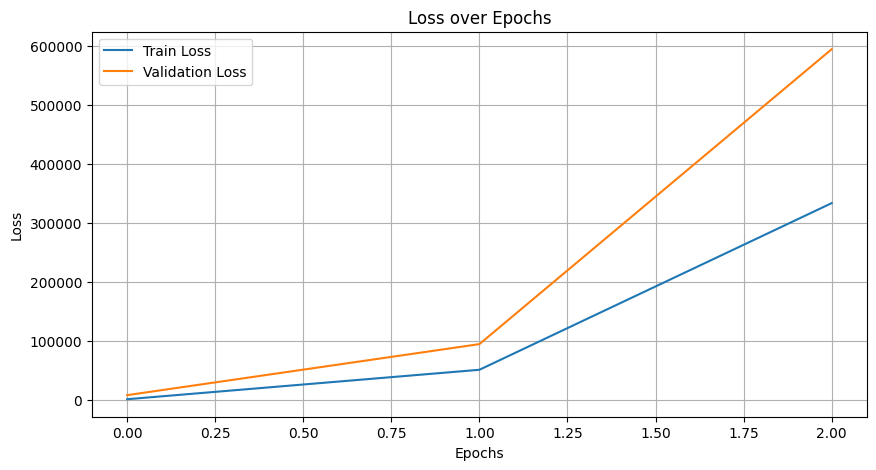

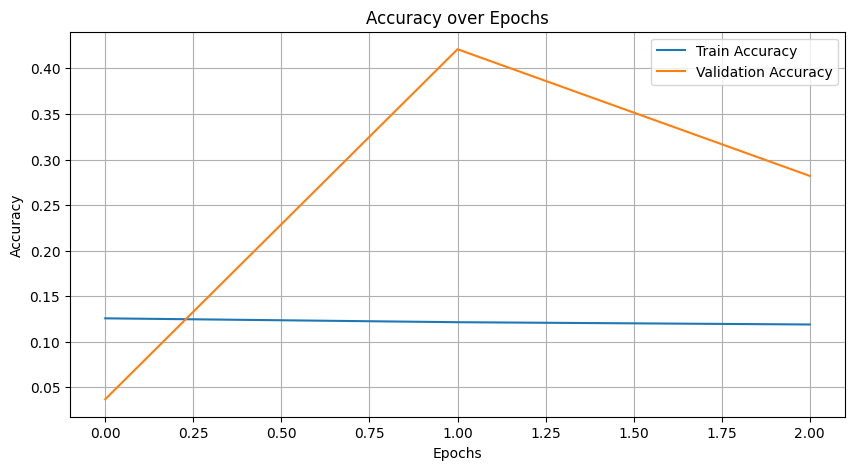

In [ ]:
# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(history_dsz_survival_data.history['loss'], label='Train Loss')
plt.plot(history_dsz_survival_data.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(history_dsz_survival_data.history['accuracy'], label='Train Accuracy')
plt.plot(history_dsz_survival_data.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()


# GoogleNET

Proposed by researchers at Google (alongside various universities), this architecture is 22 layers
deep and introduces several innovative features like 1x1 convolutions and inception modules.

Another key feature is the use of Global Average Pooling which is a fully connected layer used at
the end of the network that takes a feature map of 7x7 and averages it to 1x1 which decreases the
number of trainable parameters to 0 and improves the top-1 accuracy by 0.6%
One of the breaking-through innovations of this architecture is the introduction of inception
modules of 1x1, 3x3, 5x5 convolution and 3x3 max pooling that perform in a parallel way at the
input to stack them together and generate a final output. By doing this, the convolution filters can
handle better objects at multiple scales and different sizes better than other architectures.[1]

[1]  geeks for geeks. Understanding googlenet model – cnn architecture: https://www.geeksforgeeks.org/understanding-googlenet-model-cnn-architecture/

## Baseline

Since this architecture is already trained and available, I leveraed this and use the pre-trained weights to enhance my predictions. I just fine-tuned it to adapt it for the characterization of muon tomography.

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Dropout
from tensorflow.keras.models import Model


def create_model(input_shape):
    # Load the pre-trained InceptionV3 model
    base_model = InceptionV3(weights="imagenet", include_top=False, input_tensor=Input(shape=input_shape))

    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False


    # Add custom head for material classification
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation="relu")(x)

    # Output: Material classification
    material_output = Dense(len(mlb.classes_), activation="softmax", name="material_output")(x)

    # Create the model
    model = Model(inputs=base_model.input, outputs=material_output)

    # Compile the model
    model.compile(
        optimizer='adam',
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    return model

In [ ]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np

# Convert grayscale (64x64x1) to RGB (128x128x3) as required by GoogleNet
X_resized = np.repeat(X, 3, axis=-1)  # Duplicate grayscale channel
X_resized = tf.image.resize(X_resized, (75, 75))
X_resized = X_resized.numpy() # Convert X_resized to a NumPy array

# One-hot encode material labels using MultiLabelBinarizer
mlb = MultiLabelBinarizer()  # Create a MultiLabelBinarizer instance
y_encoded = mlb.fit_transform(y)  # Use material list

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_resized, y_encoded, test_size=0.2, random_state=42)



In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
cnn_model = create_model(input_shape=(75, 75, 3))

# Train Baseline CNN
history_baseline_googlenet = cnn_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Evaluate Baseline CNN
baseline_loss_googlenet, baseline_accuracy_googlenet = cnn_model.evaluate(X_test, y_test)
print(f"Baseline CNN - Loss: {baseline_loss_googlenet}, Accuracy: {baseline_accuracy_googlenet}")

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 27s 581ms/step - accuracy: 0.1251 - loss: 21002.1523 - val_accuracy: 0.1200 - val_loss: 9237.3916
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.1426 - loss: 17433.2363 - val_accuracy: 0.1150 - val_loss: 13130.2988
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.1948 - loss: 18484.6582 - val_accuracy: 0.0700 - val_loss: 12631.1680
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.1501 - loss: 21666.5293 - val_accuracy: 0.0700 - val_loss: 33890.3242
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1184 - loss: 9242.6650
Baseline CNN - Loss: 9237.3916015625, Accuracy: 0.11999999731779099


## Survival Analysis

Since the survival analysis data is the noisiest one, I want to compare the performance of this architecture and its robustness to noise

In [ ]:
# Create survival analysis data from the colored images
survival_images_googlenet = parallel_survival_augmentation(X_resized, survival_rates, num_augmentations=5)


In [ ]:
# Normalize Survival Data for CNN Input
scaler = MinMaxScaler()

# Reshape survival_images_googlenet to 2D for MinMaxScaler
survival_images_flat = survival_images_googlenet.reshape(-1, survival_images_googlenet.shape[-1])

# Apply MinMaxScaler
survival_images_normalized = scaler.fit_transform(survival_images_flat)

# Reshape back to original dimensions for CNN input
survival_images_normalized = survival_images_normalized.reshape(-1, 75, 75, 3)

# Repeat labels to match the augmented images
y_encoded_repeated = np.repeat(y_encoded, 5, axis=0)  # Repeat each label 5 times

# Train/Test Split for Survival Data
X_train_survival, X_test_survival, y_train_survival, y_test_survival = train_test_split(
    survival_images_normalized, y_encoded_repeated, test_size=0.2, random_state=42
)

# Train CNN with Survival Data
history_survival_googlenet = cnn_model.fit(
    X_train_survival, y_train_survival, epochs=10, batch_size=32, validation_data=(X_test_survival, y_test_survival), callbacks=[early_stopping]
)

# Evaluate CNN with Survival Data
survival_loss_googlenet, survival_accuracy_googlenet = cnn_model.evaluate(X_test_survival, y_test_survival)
print(f"Survival Analysis CNN - Loss: {survival_loss_googlenet}, Accuracy: {survival_accuracy_googlenet}")

# Print Predictions
predictions = cnn_model.predict(X_test_survival)
predicted_labels = mlb.inverse_transform((predictions > 0.5).astype(int))
actual_labels = mlb.inverse_transform((y_test_survival > 0.5).astype(int))

for i, label in enumerate(predicted_labels[:10]):
    print(f"Image {i+1}: Predicted materials - {label}")

Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.0292 - loss: 18.7101 - val_accuracy: 0.0280 - val_loss: 15.0781
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.0897 - loss: 17.1460 - val_accuracy: 0.0980 - val_loss: 15.4115
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.1182 - loss: 18.4354 - val_accuracy: 0.1470 - val_loss: 18.2423
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.1280 - loss: 21.7106 - val_accuracy: 0.1680 - val_loss: 22.9674
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0271 - loss: 15.5760
Survival Analysis CNN - Loss: 15.07805061340332, Accuracy: 0.02800000086426735
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 188ms/step
Image 1: Predicted materials - ('Steel',)
Image 2: Predicted materials - ('Steel',)
Image 3: Predicted materials - ('Steel',)
Image 4: Predicted materials - ()
Image 5: Predicted materials - ('Steel',)
Image 6: Predicted materials - ()
Image 7: Predicted materials - ()
Image 8: P

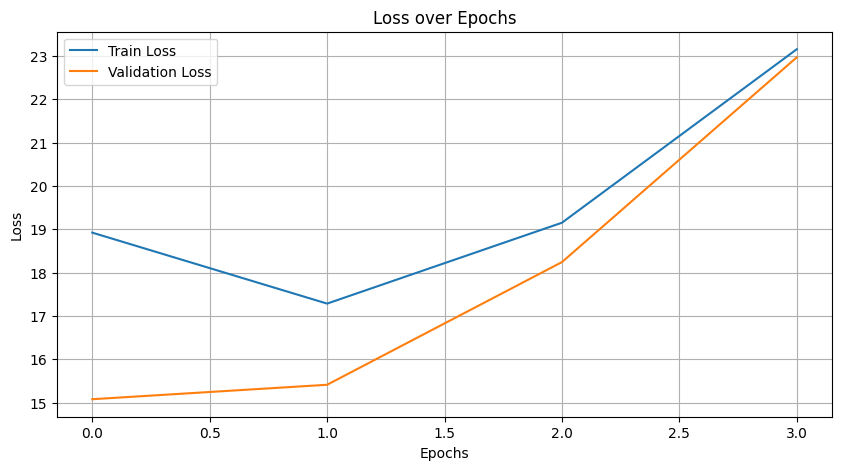

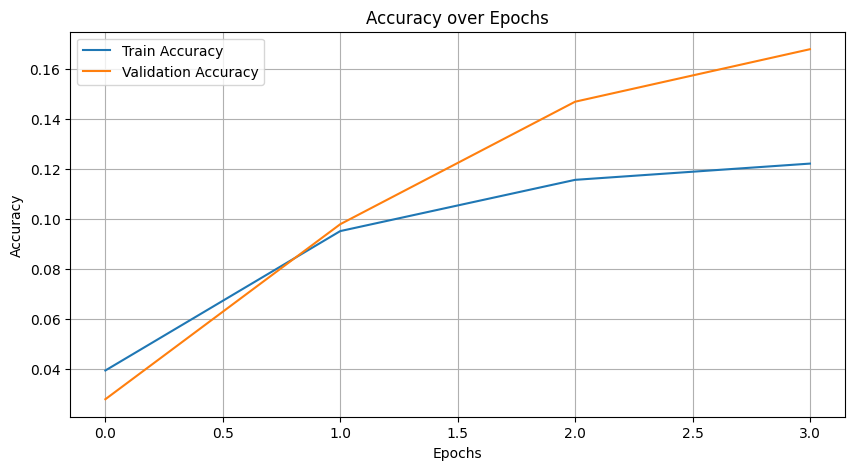

In [ ]:
# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(history_survival_googlenet.history['loss'], label='Train Loss')
plt.plot(history_survival_googlenet.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(history_survival_googlenet.history['accuracy'], label='Train Accuracy')
plt.plot(history_survival_googlenet.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()


## DSZ with survival analysis images

Since DSZ is specifically designed to capture noise in data, I want to test its capacity to handle noise from the survivival dataset (the noisest of them all) and its performance with this architecture.

In [ ]:
#  Free RAM for the next intensive task but keep historical performance to evaluate

# List of variables to keep
variables_to_keep = ['survival_images_googlenet',
                     'create_dsz_data_parallel',
                     'X_dsz_googlenet',
                     'dsz_data_generator',
                     'calculate_belief_and_plausibility_vectorized',
                     'create_probabilistic_generators_vectorized',
                     'early_stopping',
                     'create_model',
                     'InceptionV3',
                     'base_model',
                     'history_dsz_survival_data',
                     'history_survival_googlenet',
                     'history_baseline_googlenet',
                     'history_dsz_survival_data',
                     'history_dsz',
                     'history_survival',
                     'history_markov',
                     'history_poisson',
                     'history_augmented',
                     'history_baseline',
                     'survival_accuracy_googlenet', 'survival_loss_googlenet','baseline_accuracy_googlenet','baseline_loss_googlenet',
                     'dsz_accuracy_survival', 'dsz_loss_survival','dsz_accuracy','dsz_loss',
                     'survival_accuracy','survival_loss','markov_accuracy','markov_loss','poisson_accuracy','poisson_loss',
                     'augmented_accuracy','augmented_loss','baseline_accuracy','baseline_loss']

# Get all variables in the current namespace
all_variables = dir()

# Delete variables not in the keep list
for var_name in all_variables:
    if var_name not in variables_to_keep and not var_name.startswith('__'):  # Exclude system variables
        del globals()[var_name]

# Force garbage collection to immediately release memory
import gc
gc.collect()

# it gives error but works. Need an error handling code

NameError: name 'variables_to_keep' is not defined

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Generate DSZ Data
X_dsz_googlenet = create_dsz_data_parallel(survival_images_googlenet, num_generators=3, noise_std=0.0)

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer, MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import numpy as np

# Initialize MultiLabelBinarizer
mlb = MultiLabelBinarizer()

y_reshaped = np.array(y)  # Convert y to a NumPy array

# Repeat the labels to match the augmented data
y_reshaped = np.repeat(y, survival_images_googlenet.shape[0] // len(y), axis=0)


y_encoded = mlb.fit_transform(y_reshaped)  # Encode the labels using MultiLabelBinarizer

# Normalize Survival Data for CNN Input
scaler = MinMaxScaler()

# Reshape survival_images_googlenet to 2D for MinMaxScaler
dsz_images_flat = X_dsz_googlenet.reshape(-1, X_dsz_googlenet.shape[-1])

# Apply MinMaxScaler
X_dsz_googlenet_normalized = scaler.fit_transform(dsz_images_flat)

# Reshape back to original dimensions for CNN input
X_dsz_googlenet_normalized = X_dsz_googlenet_normalized.reshape(-1, 75, 75, 3)

# Repeat labels to match the augmented images
y_encoded_repeated = np.repeat(y_encoded, 3, axis=0)  # Repeat each label 3 times

# Train/Test Split for DSZ Data
X_train_dsz, X_test_dsz, y_train_dsz, y_test_dsz = train_test_split(
    X_dsz_googlenet_normalized, y_encoded_repeated, test_size=0.2, random_state=42)


cnn_model_dsz = create_model(input_shape=(75, 75, 3))  # DSZ has 3 channels now (X, center, uncertainty)

# Train CNN with DSZ Data
history_dsz_googlenet = cnn_model_dsz.fit(X_train_dsz, y_train_dsz, epochs=10, batch_size=32, validation_data=(X_test_dsz, y_test_dsz), callbacks=[early_stopping])

# Evaluate CNN with Survival Data
dsz_loss_survival_googlenet, dsz_accuracy_survival_googlenet = cnn_model_dsz.evaluate(X_test_dsz, y_test_dsz)
print(f"DSZ Analysis CNN - Loss: {dsz_loss_survival_googlenet}, Accuracy: {dsz_accuracy_survival_googlenet}")

# Print Predictions
predictions = cnn_model_dsz.predict(X_test_dsz)
predicted_labels = mlb.inverse_transform((predictions > 0.5).astype(int))
actual_labels = mlb.inverse_transform((y_test_dsz > 0.5).astype(int))

for i, label in enumerate(predicted_labels[:10]):
    print(f"Image {i+1}: Predicted materials - {label}")

Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 29s 48ms/step - accuracy: 0.1092 - loss: 23.9333 - val_accuracy: 0.0307 - val_loss: 98.5984
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 25s 16ms/step - accuracy: 0.1159 - loss: 181.7988 - val_accuracy: 0.0203 - val_loss: 367.9109
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.1228 - loss: 362.0788 - val_accuracy: 0.0203 - val_loss: 547.3654
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.0300 - loss: 99.0006
DSZ Analysis CNN - Loss: 98.59839630126953, Accuracy: 0.030666666105389595
94/94 ━━━━━━━━━━━━━━━━━━━━ 11s 66ms/step
Image 1: Predicted materials - ('Uranium',)
Image 2: Predicted materials - ('Plutonium',)
Image 3: Predicted materials - ('Uranium',)
Image 4: Predicted materials - ('Plutonium',)
Image 5: Predicted materials - ('Uranium',)
Image 6: Predicted materials - ('Plutonium',)
Image 7: Predicted materials - ('Plutonium',)
Image 8: Predicted materials - ('Plutonium',)
Image 9: Predicted materials - ('Plutonium',)
I

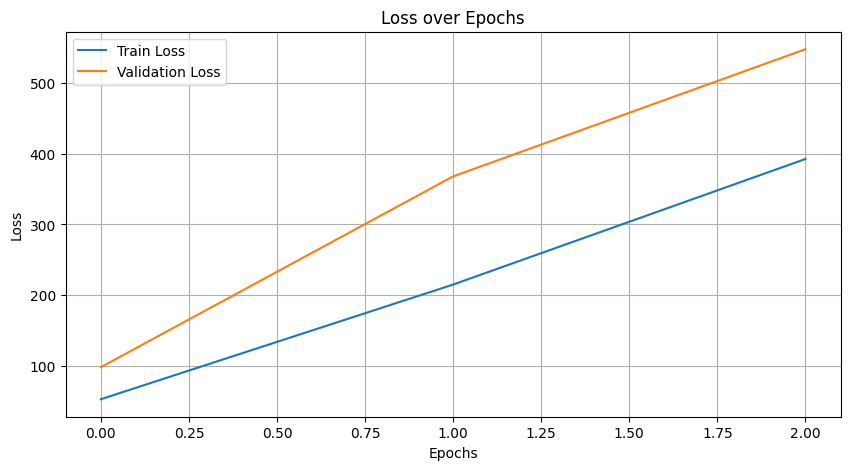

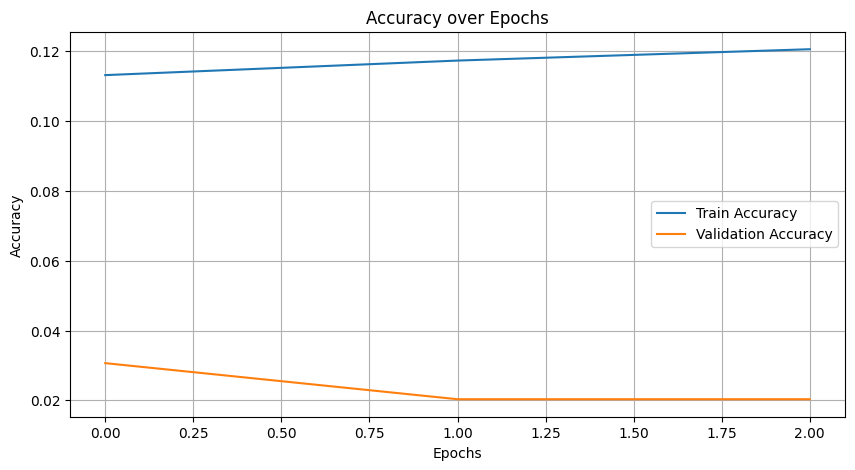

In [ ]:
import matplotlib.pyplot as plt

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(history_dsz_googlenet.history['loss'], label='Train Loss')
plt.plot(history_dsz_googlenet.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(history_dsz_googlenet.history['accuracy'], label='Train Accuracy')
plt.plot(history_dsz_googlenet.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# Results and Analysis

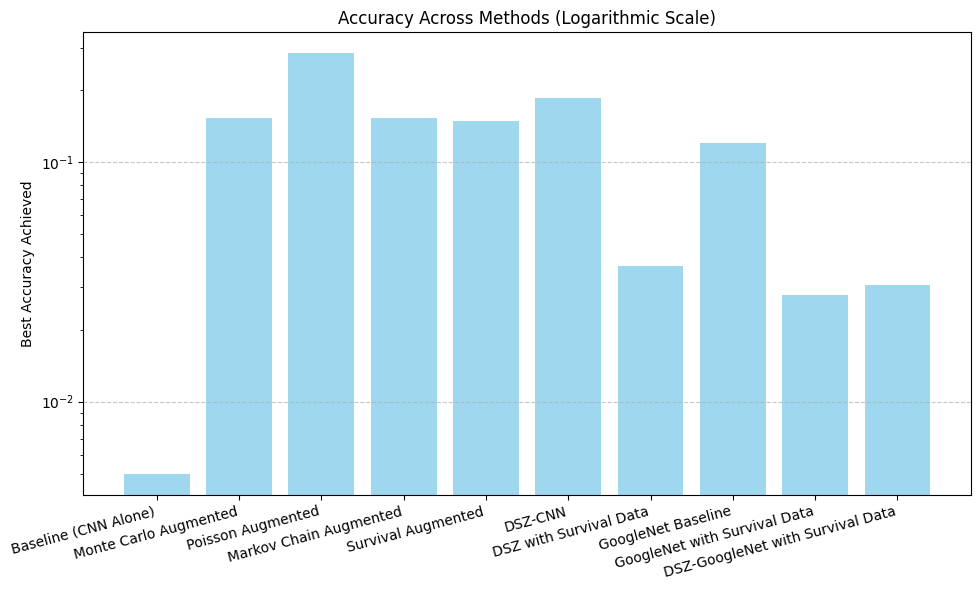

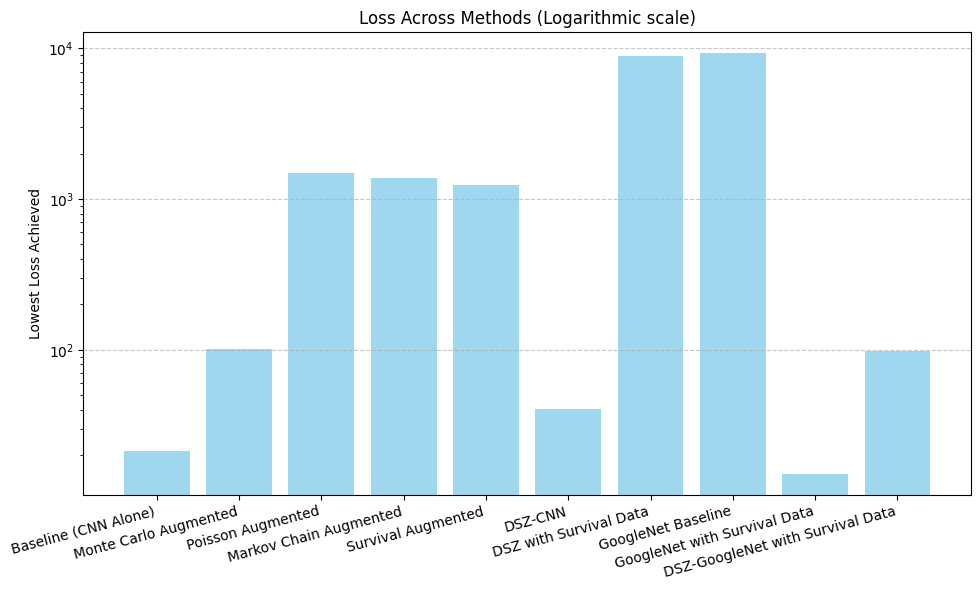

In [ ]:
import matplotlib.pyplot as plt

# Data for methods
methods = [
    "Baseline (CNN Alone)",
    "Monte Carlo Augmented",
    "Poisson Augmented",
    "Markov Chain Augmented",
    "Survival Augmented",
    "DSZ-CNN",
    "DSZ with Survival Data",
    "GoogleNet Baseline",
    "GoogleNet with Survival Data",
    "DSZ-GoogleNet with Survival Data"
]

# list of historical accuracies
accuracies = [baseline_accuracy,augmented_accuracy,poisson_accuracy,
              markov_accuracy,survival_accuracy,dsz_accuracy,
              dsz_accuracy_survival,baseline_accuracy_googlenet,
              survival_accuracy_googlenet, dsz_accuracy_survival_googlenet]

# list of historical losses
losses = [baseline_loss,augmented_loss,poisson_loss,
              markov_loss,survival_loss,dsz_loss,
              dsz_loss_survival,baseline_loss_googlenet,
              survival_loss_googlenet, dsz_loss_survival_googlenet]

# Plot for Accuracies
plt.figure(figsize=(10, 6))
plt.bar(methods, accuracies, color='skyblue', alpha=0.8)
plt.title("Accuracy Across Methods (Logarithmic Scale)")
plt.ylabel("Best Accuracy Achieved")
plt.xticks(rotation=15, ha="right")
plt.yscale('log')  # Set y-axis to logarithmic scale
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Plot for Losses
plt.figure(figsize=(10, 6))
plt.bar(methods, losses, color='skyblue', alpha=0.8)
plt.title("Loss Across Methods (Logarithmic scale)")
plt.ylabel("Lowest Loss Achieved")
plt.xticks(rotation=15, ha="right")
plt.yscale('log')  # Set y-axis to logarithmic scale
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

As we can observe, the baseline, simple 2-layered model achieves one of the lowest losses. However, counter-intuitively, this does not translate into a better accuracy rate. This discrepancy could be due to the rounding of soft predictions (which are close to the true values). When these predictions cross a threshold boundary, they may mismatch the ground truth, leading to inaccuracies. Future work could include the analysis of other metrics such as F-1 score, precision and recall to better understand what is happening with the model and refine it.

Overall, the model performs reasonably well across the different datasets, even the noisiest ones, as seen in the accuracy results. However, after multiple runs, its performance changes drastically,sometimes achieving good results and other times performing poorly. This behavior highlights the model's lack of robustness when dealing with uncertain data. Fortunately, this is not the case with the DSZ-enhanced model when using the original dataset. As shown in the graph, even with the simplest architectures, the DSZ method effectively captures uncertainty and delivers consistent results across runs.

The problem arises when noisier datasets, such as those in survival analysis, are introduced. For these datasets, the DSZ model consistently outputs one of the highest losses across runs, but this could be done because of the pre-processing of data before feeding to the network, it is worth considering a different treatment that accounts for the different channels DSZ requires and deliver high-quality images as the data seems to be too complex for the simpler model to identify underlying patterns, as also seen in the evolution of loss for the model performance which tends to increase, while for the non-DSZ structres, it tends to decrease. However, this issue is resolved when more robust architectures, such as GoogleNet, are introduced. GoogleNet performs well even with noisy data, such as that in survival analysis, and maintains consistent results across runs. This demonstrates the efficiency of robust architectures when dealing with complex, uncertain data.

That said, GoogleNet-DSZ appears promising, as it achieves better accuracy on survival data (the noisiest dataset) than GoogleNet alone, despite having a higher loss. This suggests that further refinements to the DSZ framework could improve its ability to capture noise and deliver better results. Potential refinements include introducing regularization techniques, dropout layers, larger datasets (specially to enhance accuracy as it is really low at the moment).

In conclusion, the DSZ method works best with simpler models, effectively capturing uncertainty in the data and producing robust results. However, when more advanced architectures are introduced, the inherent performance of the model takes precedence, and the DSZ method comes in second place. Nonetheless, GoogleNet-DSZ shows potential, especially with noisy data, and could be further optimized to enhance its performance.


Future work could also consider different architectures such as YOLO (You Only Look Once) and more sophisticated simulated data from Geant4 toolkit, use ensemble methods to combine predictions for more robust results such as Random Forests to enrich the learning process with varied scenarios results, LSTM to account for time-dependent scenarios such as those of Markov chains and survival analysis   or Reinforcement Learning models to reward accurate predictions enhancing the overall accuracy. Finally, grid cross-validation could be utilized to find the best hyper parameters that minimize the loss.